# Week 2: Ingest and Explore the Dataset

In [2]:
!git clone https://github.com/zhaoyangLin1008/test.git
%cd test/Notebooks
!ls ../Data


Cloning into 'test'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 262 (delta 53), reused 1 (delta 1), pack-reused 155 (from 1)
Receiving objects: 100% (262/262), 8.05 MiB | 7.47 MiB/s, done.
Resolving deltas: 100% (102/102), done.
/content/test/Notebooks
 cpi		       'stock price'			  week4_train.csv
 dgs10_m_20250826.csv   unemployment_msa_m_20250826.csv   week4_valid.csv
 dividends	        week4_test.csv


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import display


In [4]:
# Utilities — helper to drop duplicated columns by name/content
def drop_duplicate_columns(df, *, keep="first", verbose=True):
    before = df.shape[1]
    df1 = df.loc[:, ~df.columns.duplicated(keep=keep)]
    df2 = df1.loc[:, ~df1.T.duplicated(keep=keep)]
    removed = before - df2.shape[1]
    if verbose and removed > 0:
        print(f"[drop_duplicate_columns] removed {removed} duplicated columns")
    return df2
# Data import
DATA_DIR = Path("../Data")
OUT_DIR  = Path("../Reports/w2_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
# raw dataset Overlook
def try_infer_date_column(df):
    """Guess a date column from common names or by parsing"""
    candidates = ["date", "Date", "DATE", "observation_date", "Ex-Date", "ex_date"]
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: try parsing each column
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c].head(30), errors="coerce")
            if parsed.notna().mean() > 0.6:
                return c
        except Exception:
            pass
    return None

csv_files = sorted([p for p in DATA_DIR.glob("*.csv")])
if not csv_files:
    print("[WARN] No CSV files found in /content. Please upload your data files.")
else:
    overview_rows = []
    for path in csv_files:
        df = pd.read_csv(path)

        # basic info
        nrows, ncols = df.shape
        dcol = try_infer_date_column(df)

        # check date range
        date_min, date_max = None, None
        if dcol is not None:
            dt = pd.to_datetime(df[dcol], errors="coerce")
            if dt.notna().any():
                date_min = str(dt.min().date())
                date_max = str(dt.max().date())

        num_cols = df.select_dtypes(include=[np.number]).shape[1]
        non_num_cols = ncols - num_cols

        # save a small sample for reference
        df.head(10).to_csv(OUT_DIR / f"sample__{path.stem}.csv", index=False)

        overview_rows.append({
            "filename": path.name,
            "rows": nrows,
            "cols": ncols,
            "date_col": dcol,
            "date_min": date_min,
            "date_max": date_max,
            "numeric_cols": num_cols,
            "non_numeric_cols": non_num_cols,
            "columns_preview": ", ".join(map(str, df.columns[:6]))
        })

        print(f"[CHECK] {path.name}: shape={df.shape}, "
              f"date_col={dcol}, date_range=({date_min}, {date_max})")

    # build overview table
    overview = pd.DataFrame(overview_rows).sort_values("filename").reset_index(drop=True)
    overview.to_csv(OUT_DIR / "files_overview.csv", index=False)

    # show as a table in notebook
    display(overview.head())
    print("\nOverview saved to:", OUT_DIR / "files_overview.csv")


[CHECK] dgs10_m_20250826.csv: shape=(764, 3), date_col=date, date_range=(1962-01-31, 2025-08-31)
[CHECK] unemployment_msa_m_20250826.csv: shape=(2550, 4), date_col=date, date_range=(1990-01-01, 2025-06-01)
[CHECK] week4_test.csv: shape=(116, 23), date_col=date, date_range=(2024-01-31, 2025-08-31)
[CHECK] week4_train.csv: shape=(538, 23), date_col=date, date_range=(2014-12-31, 2022-05-31)
[CHECK] week4_valid.csv: shape=(115, 23), date_col=date, date_range=(2022-05-31, 2023-12-31)


,filename,rows,cols,date_col,date_min,date_max,numeric_cols,non_numeric_cols,columns_preview
0,dgs10_m_20250826.csv,764,3,date,1962-01-31,2025-08-31,1,2,"date, series_id, value"
1,unemployment_msa_m_20250826.csv,2550,4,date,1990-01-01,2025-06-01,1,3,"date, series_id, value, city"
2,week4_test.csv,116,23,date,2024-01-31,2025-08-31,9,14,"date, cpi, cpi_yoy, cpi_mom, unemp, unemp_mom"
3,week4_train.csv,538,23,date,2014-12-31,2022-05-31,9,14,"date, cpi, cpi_yoy, cpi_mom, unemp, unemp_mom"
4,week4_valid.csv,115,23,date,2022-05-31,2023-12-31,9,14,"date, cpi, cpi_yoy, cpi_mom, unemp, unemp_mom"



Overview saved to: ../Reports/w2_out/files_overview.csv


In [6]:
# Data basic standardization and simple engineer features
#covert data to monthly
def to_month_end(s):
    """Convert date to month-end date"""
    dt = pd.to_datetime(s, errors="coerce")
    return (dt + pd.offsets.MonthEnd(0)).dt.normalize()

#calculate the fluctuation of month to month
def level_diff(s, periods=1):
    """Month-to-month difference"""
    return s.diff(periods=periods)

#take the last price in a month
def mon_agg_last(x):
    """Get the last available value in a month"""
    return x.dropna().iloc[-1] if x.notna().any() else np.nan

#convert the stock price to monthly
def month_end_close(price_df, date_col="Date", close_col="Close"):
    tmp = price_df.copy()
    tmp[date_col] = to_month_end(tmp[date_col])
    tmp[close_col] = pd.to_numeric(tmp[close_col], errors="coerce")
    out = (tmp.groupby(date_col, as_index=False)[close_col]
              .agg(mon_agg_last)
              .rename(columns={date_col: "date", close_col: "adj_price"}))
    return out
#claculate monthly dividents
def monthly_sum_by_exdate(div_df, date_col="Ex-Date", amt_col="Amount"):
    tmp = div_df.copy()
    tmp[date_col] = to_month_end(tmp[date_col])
    tmp[amt_col] = pd.to_numeric(tmp[amt_col], errors="coerce")
    out = (tmp.groupby(date_col, as_index=False)[amt_col]
              .sum()
              .rename(columns={date_col: "date", amt_col: "dividend"}))
    return out
# divident of a year
def compute_ttm_dividend(div_monthly):
    s = div_monthly.sort_values("date")["dividend"].fillna(0.0)
    return s.rolling(window=12, min_periods=1).sum()


In [7]:
# map the company and city
COMPANY_TO_METRO = {
    "BXP":  "Boston",
    "SLG":  "New York",
    "ELME": "Washington",
    "EQR":  "Chicago",
    "REXR": "Los Angeles",
    "TRNO": "Miami",
}

# the dividents and price of company
COMPANY_FILES = {
    "BXP":  ("stock price/bxp_prices.csv",  "dividends/bxp_dividends.csv"),
    "ELME": ("stock price/elme_prices.csv", "dividends/elme_dividends.csv"),
    "EQR":  ("stock price/eqr_prices.csv",  "dividends/eqr_dividends.csv"),
    "REXR": ("stock price/rexr_prices.csv", "dividends/rexr_dividends.csv"),
    "SLG":  ("stock price/slg_prices.csv",  "dividends/slg_dividends.csv"),
    "TRNO": ("stock price/trno_prices.csv", "dividends/trno_dividends.csv"),
}

In [8]:
#Data cleaning
#First aspect --- Firms' data (price and dividents)
company_tables = []
for tic, (price_file, div_file) in COMPANY_FILES.items():
  #read the raw data
    px_raw = pd.read_csv(DATA_DIR / price_file)
    dv_raw = pd.read_csv(DATA_DIR / div_file)
    print(f"[{tic}] raw shapes -> prices={px_raw.shape}, dividends={dv_raw.shape}")

    # git rid of same rows
    px = px_raw.drop_duplicates().copy()
    dv = dv_raw.drop_duplicates().copy()
    # standardize time
    px["Date"] = pd.to_datetime(px["Date"], errors="coerce")
    dv["Ex-Date"] = pd.to_datetime(dv["Ex-Date"], errors="coerce")
    #transfer numbers to folat and non numbers to NAN
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    dv["Amount"] = pd.to_numeric(dv["Amount"], errors="coerce")
    #Get rid of NANs
    px = px[px["Date"].notna() & px["Close"].notna()]
    dv = dv[dv["Ex-Date"].notna() & dv["Amount"].notna()]

    # monthly level
    px_m = month_end_close(px)
    dv_m = monthly_sum_by_exdate(dv)

    #take the same time period
    if not dv_m.empty and not px_m.empty:
     min_date = max(px_m["date"].min(), dv_m["date"].min())
     max_date = min(px_m["date"].max(), dv_m["date"].max())
     px_m = px_m[(px_m["date"] >= min_date) & (px_m["date"] <= max_date)]
     dv_m = dv_m[(dv_m["date"] >= min_date) & (dv_m["date"] <= max_date)]

    # merge and claculate TTM
    cur = (pd.merge(px_m, dv_m, on="date", how="left")
             .sort_values("date")
             .assign(dividend=lambda d: d["dividend"].fillna(0.0)))
    cur["dividend_ttm"] = compute_ttm_dividend(cur)
    cur["company"] = tic

    print(f"[{tic}] monthly rows={cur.shape[0]}, "
          f"range=({cur['date'].min().date()}, {cur['date'].max().date()})")

    company_tables.append(cur[["date","company","adj_price","dividend","dividend_ttm"]])

all_companies = pd.concat(company_tables, ignore_index=True)
all_companies.to_csv(OUT_DIR / "step2_company_monthly_all.csv", index=False)
print("[all_companies] shape:", all_companies.shape)
display(all_companies.head(20))


[BXP] raw shapes -> prices=(247, 6), dividends=(55, 3)
[BXP] monthly rows=127, range=(2014-12-31, 2025-06-30)
[ELME] raw shapes -> prices=(247, 6), dividends=(55, 3)
[ELME] monthly rows=128, range=(2015-01-31, 2025-08-31)
[EQR] raw shapes -> prices=(385, 6), dividends=(55, 3)
[EQR] monthly rows=127, range=(2014-12-31, 2025-06-30)
[REXR] raw shapes -> prices=(146, 6), dividends=(55, 3)
[REXR] monthly rows=129, range=(2014-12-31, 2025-08-31)
[SLG] raw shapes -> prices=(247, 6), dividends=(98, 3)
[SLG] monthly rows=129, range=(2014-12-31, 2025-08-31)
[TRNO] raw shapes -> prices=(187, 6), dividends=(55, 3)
[TRNO] monthly rows=129, range=(2014-12-31, 2025-08-31)
[all_companies] shape: (769, 5)


,date,company,adj_price,dividend,dividend_ttm
0,2014-12-31,BXP,100.7570,5.80,5.80
1,2015-01-31,BXP,108.6960,7.75,13.55
2,2015-02-28,BXP,107.6030,0.00,13.55
3,2015-03-31,BXP,110.5230,0.65,14.20
4,2015-04-30,BXP,104.0960,0.00,14.20
5,2015-05-31,BXP,102.2990,0.00,14.20
6,2015-06-30,BXP,95.7034,0.65,14.85
7,2015-07-31,BXP,97.5042,0.00,14.85
8,2015-08-31,BXP,89.6563,0.00,14.85
9,2015-09-30,BXP,94.1603,0.65,15.50


In [9]:
#Data cleaning
#Second aspect --- CPI and umemployment
#CPI
CPI_FILES = {
    "Boston":      "cpi/la_cpi_boston.csv",
    "Chicago":     "cpi/la_cpi_chicago.csv",
    "Los Angeles": "cpi/la_cpi_los_angeles.csv",
    "Miami":       "cpi/la_cpi_miami.csv",
    "New York":    "cpi/la_cpi_ny.csv",
    "Washington":  "cpi/la_cpi_Washington.csv",
}
cpi_tables = []

for city, fname in CPI_FILES.items():
    path = DATA_DIR / fname
    if not path.exists():
        print(f"[WARN] Missing CPI file for {city}")
        continue

    df = pd.read_csv(path)
    if "date" in df.columns:
        dcol = "date"
    elif "DATE" in df.columns:
        dcol = "DATE"
    elif "observation_date" in df.columns:
        dcol = "observation_date"
    else:
        dcol = df.columns[0]

    vcol = "value" if "value" in df.columns else df.columns[-1]

    df = df[[dcol, vcol]].rename(columns={dcol:"date", vcol:"cpi"})
    df["date"] = to_month_end(df["date"])
    df["cpi"]  = pd.to_numeric(df["cpi"], errors="coerce")
    df = df[df["date"].notna() & df["cpi"].notna()].drop_duplicates()
    df = df.sort_values("date")

    # engineer features
    df["cpi_yoy"] = df["cpi"]/df["cpi"].shift(12) - 1
    df["cpi_mom"] = df["cpi"]/df["cpi"].shift(1)  - 1
    df["metro"]   = city

    cpi_tables.append(df[["date","metro","cpi","cpi_yoy","cpi_mom"]])

# merge all COI
cpi_all = pd.concat(cpi_tables, ignore_index=True) if cpi_tables else pd.DataFrame()
cpi_all.to_csv(OUT_DIR / "step3_cpi_all.csv", index=False)

print("CPI total shape:", cpi_all.shape)
display(cpi_all.head(10))

#Unemployment
unemp_path = DATA_DIR / "unemployment_msa_m_20250826.csv"
if not unemp_path.exists():
    print("[WARN] Unemployment file missing")
    unemp = pd.DataFrame(columns=["metro","date","unemp","unemp_mom"])
else:
    df = pd.read_csv(unemp_path)

    # standardize date and time
    df["date"]  = to_month_end(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df[df["date"].notna() & df["value"].notna()].drop_duplicates()

    # metro data to the city
    df["metro"] = None
    for city in set(COMPANY_TO_METRO.values()):
        df.loc[df["city"].str.contains(city, na=False), "metro"] = city
    df = df.dropna(subset=["metro"])

    # take average to month
    unemp = (df.groupby(["metro","date"], as_index=False)["value"]
               .mean()
               .rename(columns={"value":"unemp"}))
    # month to month and year to year data
    unemp = unemp.sort_values(["metro","date"])
    unemp["unemp_mom"] = unemp.groupby("metro")["unemp"].transform(level_diff)

unemp.to_csv(OUT_DIR / "step4_unemployment_all.csv", index=False)

print("Unemployment shape:", unemp.shape)
display(unemp.head(10))


CPI total shape: (4004, 5)


,date,metro,cpi,cpi_yoy,cpi_mom
0,1914-12-31,Boston,10.5,NaN,NaN
1,1915-12-31,Boston,10.7,NaN,0.019048
2,1916-12-31,Boston,12.1,NaN,0.130841
3,1917-12-31,Boston,14.2,NaN,0.173554
4,1918-12-31,Boston,17.3,NaN,0.218310
5,1919-06-30,Boston,17.4,NaN,0.005780
6,1919-12-31,Boston,19.5,NaN,0.120690
7,1920-06-30,Boston,21.5,NaN,0.102564
8,1920-12-31,Boston,20.2,NaN,-0.060465
9,1921-05-31,Boston,18.0,NaN,-0.108911


Unemployment shape: (2550, 4)


,metro,date,unemp,unemp_mom
0,Boston,1990-01-31,5.3,NaN
1,Boston,1990-02-28,5.2,-0.1
2,Boston,1990-03-31,5.3,0.1
3,Boston,1990-04-30,5.4,0.1
4,Boston,1990-05-31,5.5,0.1
5,Boston,1990-06-30,5.7,0.2
6,Boston,1990-07-31,5.9,0.2
7,Boston,1990-08-31,6.1,0.2
8,Boston,1990-09-30,6.3,0.2
9,Boston,1990-10-31,6.5,0.2


In [10]:
#Data cleaning
#Third aspect --- 10Y Treasury
ust10_path = DATA_DIR / "dgs10_m_20250826.csv"
if not ust10_path.exists():
    warnings.warn("10Y file missing: dgs10_m_20250826.csv")
    ust10 = pd.DataFrame(columns=["date","ten_year","ten_year_mom"])
else:
    ust10 = pd.read_csv(ust10_path)
    # sequence as the date
    ust10["date"] = to_month_end(ust10["date"])
    ust10 = ust10.sort_values("date")
    # calculate month to month change
    ust10["ten_year"] = pd.to_numeric(ust10["value"], errors="coerce")
    ust10["ten_year_mom"] = ust10["ten_year"].diff(periods=1)
    # only keep the standard rows
    ust10 = ust10[["date","ten_year","ten_year_mom"]]

# save the file
ust10.to_csv(OUT_DIR / "step5_ust10.csv", index=False)
print("[ust10] shape:", ust10.shape)
if not ust10.empty:
    print(f"[ust10] range=({ust10['date'].min().date()}, {ust10['date'].max().date()})")
display(ust10.tail(10))

[ust10] shape: (764, 3)
[ust10] range=(1962-01-31, 2025-08-31)


,date,ten_year,ten_year_mom
754,2024-11-30,4.355789,0.260335
755,2024-12-31,4.391429,0.035639
756,2025-01-31,4.629048,0.237619
757,2025-02-28,4.451053,-0.177995
758,2025-03-31,4.280476,-0.170576
759,2025-04-30,4.279048,-0.001429
760,2025-05-31,4.423810,0.144762
761,2025-06-30,4.383500,-0.040310
762,2025-07-31,4.391818,0.008318
763,2025-08-31,4.270625,-0.121193


In [11]:
# Final merge: all data sources into one table
# Purpose: join sources, attach metro, de-duplicate columns, quick checks, then save.

# all companies
all_companies = pd.concat(company_tables, ignore_index=True)

# name of the city
all_companies["metro"] = all_companies["company"].map(COMPANY_TO_METRO)

# CPI
df_merged = pd.merge(all_companies, cpi_all, on=["date", "metro"], how="left")
# Unemployment rate
df_merged = pd.merge(df_merged, unemp, on=["date", "metro"], how="left")
# 10Y yield
df_merged = pd.merge(df_merged, ust10, on="date", how="left")

# de-duplicate columns BEFORE export
df_merged = drop_duplicate_columns(df_merged)

# save and display
df_merged.to_csv(OUT_DIR / "final_dataset.csv", index=False)
print("final_dataset shape:", df_merged.shape)
display(df_merged.head(20))


final_dataset shape: (769, 13)


,date,company,adj_price,dividend,dividend_ttm,metro,cpi,cpi_yoy,cpi_mom,unemp,unemp_mom,ten_year,ten_year_mom
0,2014-12-31,BXP,100.7570,5.80,5.80,Boston,NaN,NaN,NaN,4.7,-0.1,2.207273,-0.118283
1,2015-01-31,BXP,108.6960,7.75,13.55,Boston,254.556,0.018399,-0.006657,4.7,0.0,1.881500,-0.325773
2,2015-02-28,BXP,107.6030,0.00,13.55,Boston,NaN,NaN,NaN,4.6,-0.1,1.975263,0.093763
3,2015-03-31,BXP,110.5230,0.65,14.20,Boston,257.013,0.024630,0.009652,4.5,-0.1,2.042727,0.067464
4,2015-04-30,BXP,104.0960,0.00,14.20,Boston,NaN,NaN,NaN,4.5,0.0,1.935000,-0.107727
5,2015-05-31,BXP,102.2990,0.00,14.20,Boston,256.839,0.027208,-0.000677,4.4,-0.1,2.197500,0.262500
6,2015-06-30,BXP,95.7034,0.65,14.85,Boston,NaN,NaN,NaN,4.4,0.0,2.363636,0.166136
7,2015-07-31,BXP,97.5042,0.00,14.85,Boston,256.999,0.023627,0.000623,4.3,-0.1,2.324545,-0.039091
8,2015-08-31,BXP,89.6563,0.00,14.85,Boston,NaN,NaN,NaN,4.2,-0.1,2.167143,-0.157403
9,2015-09-30,BXP,94.1603,0.65,15.50,Boston,256.643,0.018756,-0.001385,4.2,0.0,2.172857,0.005714


# Week 3: Data Split & EDA START

Verify the basic quality of merged data: date formats, deduplication, and sorting.
Ensure the dataset is clean and well-organized for subsequent splitting and modeling.

In [12]:
# Step 1: Data existence and basic validation
def drop_duplicate_columns(df):
    """Remove duplicate columns by name or by identical content"""
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.loc[:, ~df.T.duplicated()]
    return df

# Ensure the 'date' column is in datetime format and align dates to the end of the month (for easier time series segmentation)
df_merged["date"] = pd.to_datetime(df_merged["date"])
df_merged["date"] = df_merged["date"] + pd.offsets.MonthEnd(0)

# Report duplicate rows/columns BEFORE dropping
dup_rows = df_merged.duplicated(subset=["company","date"]).sum()
dup_cols = df_merged.columns.duplicated().sum()
print(f"Duplicate rows before drop: {dup_rows}, duplicate columns: {dup_cols}")

# Remove duplicate rows/columns and sort the data
df_merged = df_merged.drop_duplicates(subset=["company","date"]).sort_values(["company","date"]).reset_index(drop=True)
df_merged = drop_duplicate_columns(df_merged)

# Check data types and missing values
print("\ndata types:")
print(df_merged.dtypes)

print("\nisna:")
print(df_merged.isna().sum())

# Display the time range for each company
print("\ntime range for each company:")
time_ranges = df_merged.groupby("company")["date"].agg(["min", "max", "count"])
print(time_ranges)

# Print the first 5 rows
print("\nhead:")
print(df_merged.head())

Duplicate rows before drop: 0, duplicate columns: 0

data types:
date            datetime64[ns]
company                 object
adj_price              float64
dividend               float64
dividend_ttm           float64
metro                   object
cpi                    float64
cpi_yoy                float64
cpi_mom                float64
unemp                  float64
unemp_mom              float64
ten_year               float64
ten_year_mom           float64
dtype: object

isna:
date              0
company           0
adj_price         0
dividend          0
dividend_ttm      0
metro             0
cpi             287
cpi_yoy         287
cpi_mom         287
unemp            14
unemp_mom        14
ten_year          0
ten_year_mom      0
dtype: int64

time range for each company:
               min        max  count
company                             
BXP     2014-12-31 2025-06-30    127
ELME    2015-01-31 2025-08-31    128
EQR     2014-12-31 2025-06-30    127
REXR    2014-12-31 2025

Split the data into training, validation, and test sets based on time sequence.
Preserve the integrity of the time series to prevent leakage of future information.

In [13]:
# Step 2: Dataset Splitting (Train / Validation / Test)

# Sort by chronological order to avoid future data leakage
df_sorted = df_merged.sort_values("date").reset_index(drop=True)

# Calculate split indices
n_total = len(df_sorted)
train_end = int(n_total * 0.7)
valid_end = int(n_total * 0.85)

# Split the dataset
train_df = df_sorted.iloc[:train_end]
valid_df = df_sorted.iloc[train_end:valid_end]
test_df  = df_sorted.iloc[valid_end:]

print("Dataset split summary:")
print(f"Total samples: {n_total}")
print(f"Training set: {train_df.shape}, Date range {train_df['date'].min().date()} → {train_df['date'].max().date()}")
print(f"Validation set: {valid_df.shape}, Date range {valid_df['date'].min().date()} → {valid_df['date'].max().date()}")
print(f"Test set: {test_df.shape}, Date range {test_df['date'].min().date()} → {test_df['date'].max().date()}")



Dataset split summary:
Total samples: 769
Training set: (538, 13), Date range 2014-12-31 → 2022-05-31
Validation set: (115, 13), Date range 2022-05-31 → 2023-12-31
Test set: (116, 13), Date range 2024-01-31 → 2025-08-31


Output descriptive statistics and missing value statistics on the training set.
The first step in EDA, helping to understand the basic distribution of the data and potential issues.

In [14]:
# Step 3.1: Descriptive statistics and missing value check for the training set

print("Training set size:")
print(train_df.shape)

# 1. Descriptive statistics
print("\nDescriptive statistics:")
display(train_df.describe(include="all").T)

# 2. Missing value statistics
print("\nMissing value statistics:")
missing_stats = train_df.isna().sum().to_frame("missing_count")
missing_stats["missing_pct"] = (missing_stats["missing_count"] / len(train_df)) * 100
display(missing_stats)

# 3. Number of observations per company
print("\nNumber of observations per company:")
company_counts = train_df["company"].value_counts().to_frame("n_obs")
display(company_counts)

# 4. Time range check (within training set)
print("\nTime range of the training set:")
time_ranges_train = train_df.groupby("company")["date"].agg(["min","max","count"])
display(time_ranges_train)


Training set size:
(538, 13)

Descriptive statistics:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,538,NaN,NaN,NaN,2018-09-14 21:35:27.881040896,2014-12-31 00:00:00,2016-10-31 00:00:00,2018-09-15 00:00:00,2020-07-31 00:00:00,2022-05-31 00:00:00,NaN
company,538,6,BXP,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adj_price,538.0,NaN,NaN,NaN,54.927262,11.0497,25.7296,52.97335,74.4686,128.345,29.938724
dividend,538.0,NaN,NaN,NaN,0.406259,0.0,0.0,0.0,0.31395,13.0638,1.037778
dividend_ttm,538.0,NaN,NaN,NaN,4.578889,0.12,1.795,3.0,6.483125,26.1277,4.10602
metro,538,6,Boston,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpi,351.0,NaN,NaN,NaN,262.11314,225.763,246.0505,261.347,276.2095,316.525,20.153259
cpi_yoy,351.0,NaN,NaN,NaN,0.029463,-0.009328,0.014409,0.021963,0.044752,0.136389,0.022881
cpi_mom,351.0,NaN,NaN,NaN,0.003204,-0.010318,-0.000329,0.00237,0.006048,0.027871,0.005547
unemp,538.0,NaN,NaN,NaN,5.173234,2.6,3.6,4.4,5.7,19.0,2.58203



Missing value statistics:


,missing_count,missing_pct
date,0,0.000000
company,0,0.000000
adj_price,0,0.000000
dividend,0,0.000000
dividend_ttm,0,0.000000
metro,0,0.000000
cpi,187,34.758364
cpi_yoy,187,34.758364
cpi_mom,187,34.758364
unemp,0,0.000000



Number of observations per company:


,n_obs
company,
BXP,90
TRNO,90
SLG,90
EQR,90
REXR,89
ELME,89



Time range of the training set:


,min,max,count
company,,,
BXP,2014-12-31,2022-05-31,90
ELME,2015-01-31,2022-05-31,89
EQR,2014-12-31,2022-05-31,90
REXR,2014-12-31,2022-04-30,89
SLG,2014-12-31,2022-05-31,90
TRNO,2014-12-31,2022-05-31,90


Plot histograms and grouped boxplots for numerical variables to examine distribution characteristics and differences across companies.
Identify skewness, outliers, and variations between companies/regions.

Numerical variables: ['adj_price', 'dividend', 'dividend_ttm', 'cpi', 'cpi_yoy', 'cpi_mom', 'unemp', 'unemp_mom', 'ten_year', 'ten_year_mom']


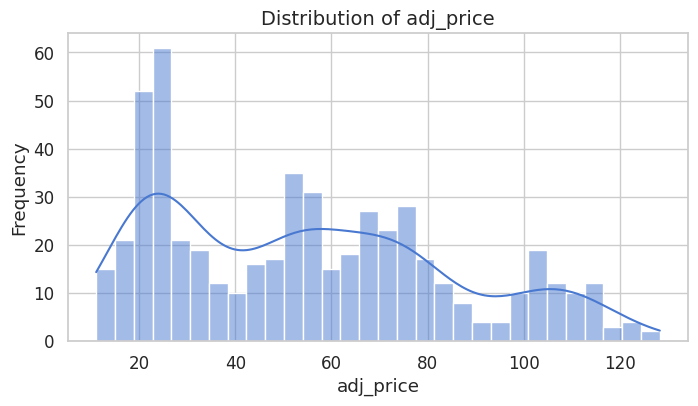

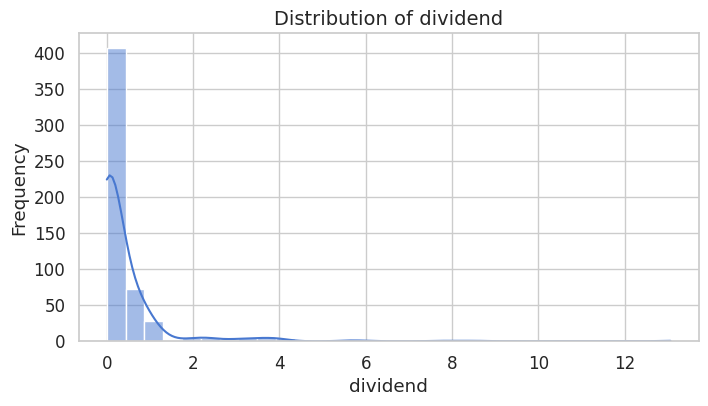

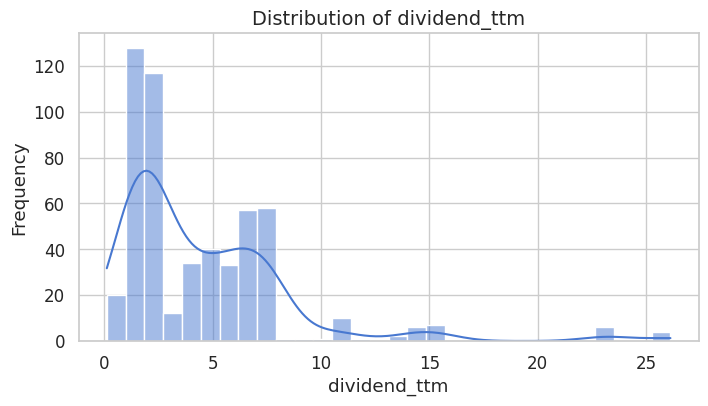

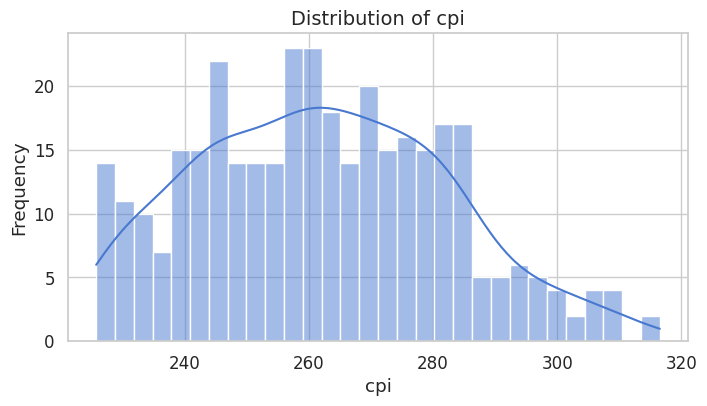

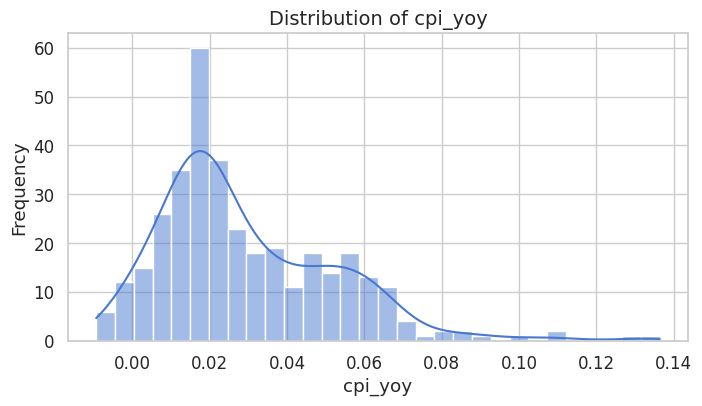

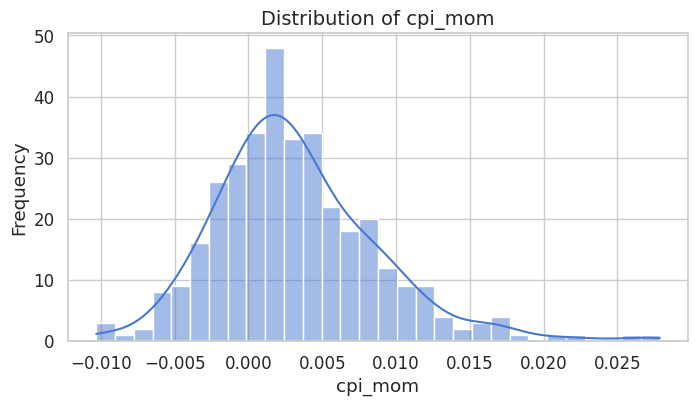

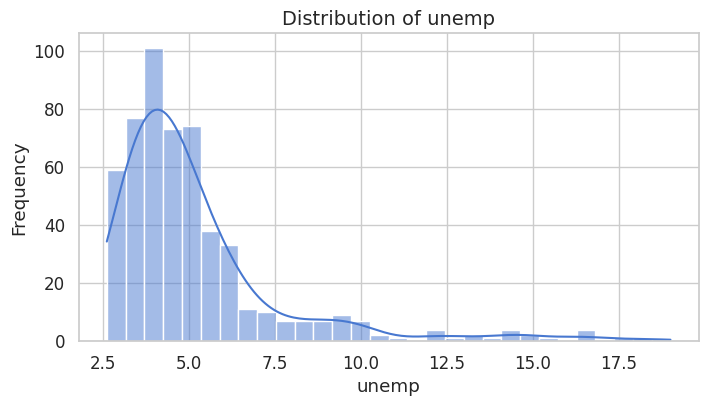

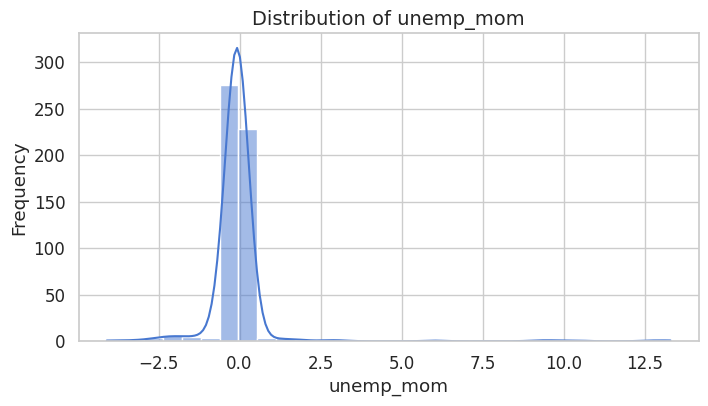

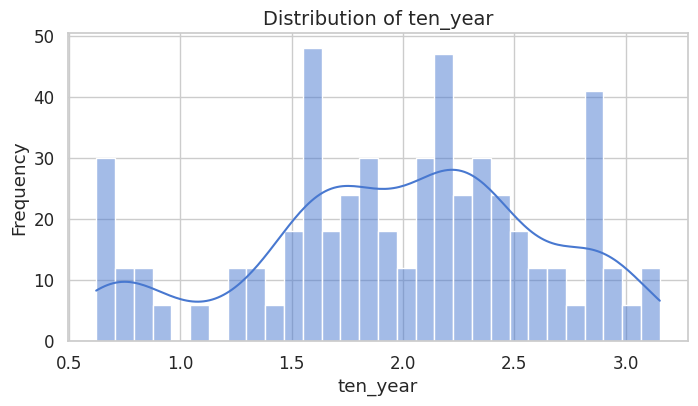

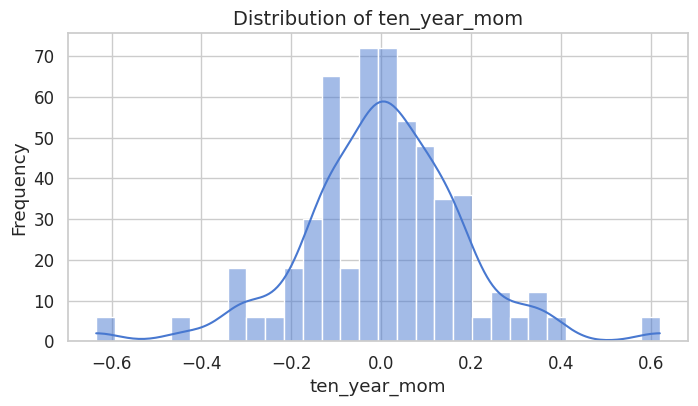

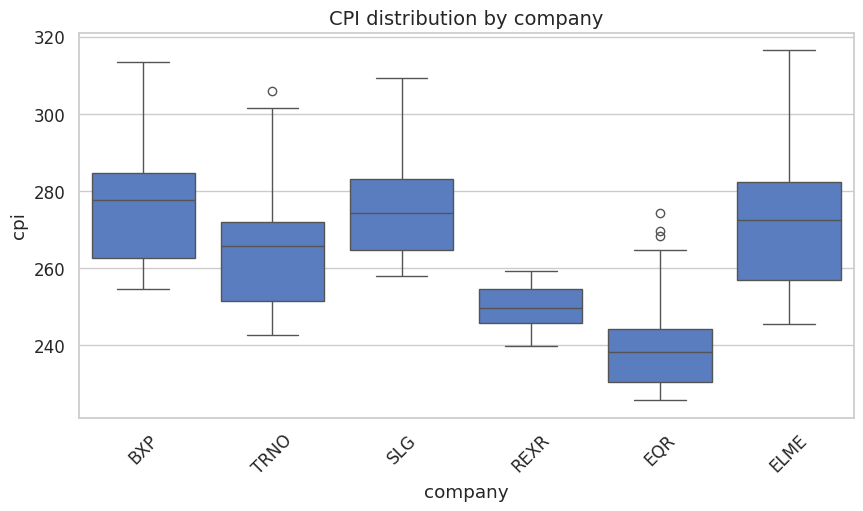

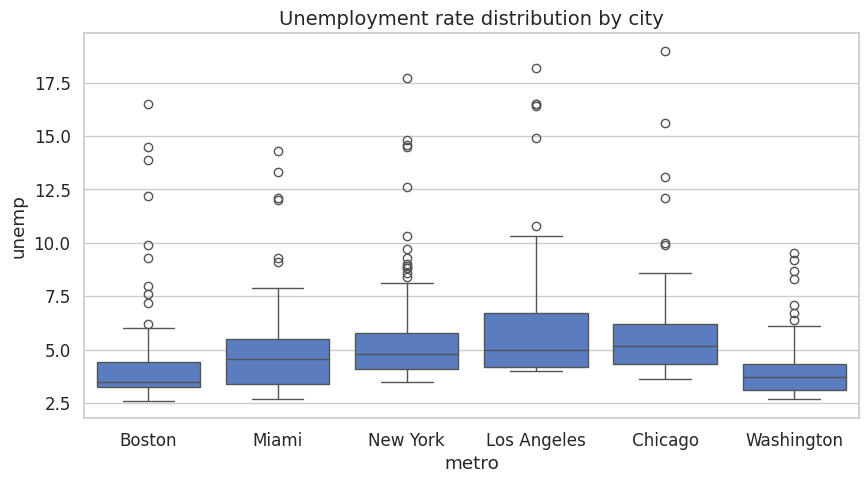

In [15]:
# Step 3.2: Variable distribution visualization (Training set)

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Select numerical features (excluding date and categorical variables)
num_cols = train_df.select_dtypes(include=["float64", "int64"]).columns

print("Numerical variables:", num_cols.tolist())

# 1. Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# 2. Comparison across companies/regions (using CPI as an example)
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="company", y="cpi")
plt.title("CPI distribution by company", fontsize=14)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="metro", y="unemp")
plt.title("Unemployment rate distribution by city", fontsize=14)
plt.show()


Calculate the correlation between numerical variables and plot a heatmap.
Explore linear relationships among variables to determine if multicollinearity exists.

Correlation matrix of numerical variables:


,adj_price,dividend,dividend_ttm,cpi,cpi_yoy,cpi_mom,unemp,unemp_mom,ten_year,ten_year_mom
adj_price,1.000000,0.196598,0.524375,0.262500,0.038913,0.052025,-0.102272,-0.010750,-0.002515,0.045657
dividend,0.196598,1.000000,0.287565,-0.012953,-0.083534,0.074500,-0.017832,-0.020127,-0.004540,-0.041438
dividend_ttm,0.524375,0.287565,1.000000,-0.035349,-0.185490,-0.059667,0.031208,-0.006864,-0.059679,0.038203
cpi,0.262500,-0.012953,-0.035349,1.000000,0.616430,0.362379,-0.048867,-0.034361,-0.168095,0.139841
cpi_yoy,0.038913,-0.083534,-0.185490,0.616430,1.000000,0.535181,-0.348630,-0.056443,0.148846,0.206491
cpi_mom,0.052025,0.074500,-0.059667,0.362379,0.535181,1.000000,-0.173192,-0.219157,0.038487,0.280047
unemp,-0.102272,-0.017832,0.031208,-0.048867,-0.348630,-0.173192,1.000000,0.238383,-0.659873,0.001334
unemp_mom,-0.010750,-0.020127,-0.006864,-0.034361,-0.056443,-0.219157,0.238383,1.000000,-0.074781,-0.185382
ten_year,-0.002515,-0.004540,-0.059679,-0.168095,0.148846,0.038487,-0.659873,-0.074781,1.000000,0.174271
ten_year_mom,0.045657,-0.041438,0.038203,0.139841,0.206491,0.280047,0.001334,-0.185382,0.174271,1.000000


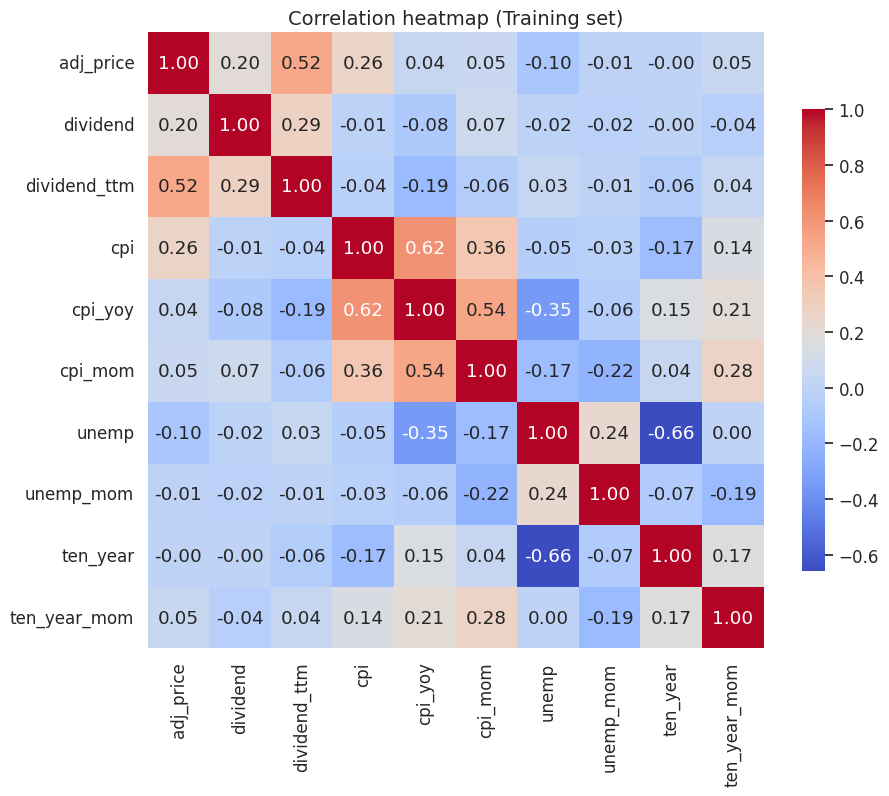

In [16]:
# Step 3.3: Correlation analysis (Training set)

# Select only numerical features
num_cols = train_df.select_dtypes(include=["float64", "int64"]).columns

# Compute Pearson correlation coefficients
corr_matrix = train_df[num_cols].corr(method="pearson")

print("Correlation matrix of numerical variables:")
display(corr_matrix)

# Visualize as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation heatmap (Training set)", fontsize=14)
plt.show()



# Week4: Make Data Model Ready

In [17]:
# Step 1: Missing Value Handling

# Backup the data
df_clean = df_merged.copy()

num_cols = ["cpi", "cpi_yoy", "cpi_mom", "unemp", "unemp_mom"]
for col in num_cols:
    df_clean[col] = (df_clean
                     .sort_values(["metro","date"])
                     .groupby("metro")[col]
                     .ffill())

medians = df_clean[num_cols].median()
df_clean[num_cols] = df_clean[num_cols].fillna(medians)

print("Missing value check: after")
print(df_clean.isna().sum())

# Save the cleaned data
df_clean.to_csv(OUT_DIR / "week4_step1_missing_cleaned.csv", index=False)
print("Cleaned data saved")


Missing value check: after
date            0
company         0
adj_price       0
dividend        0
dividend_ttm    0
metro           0
cpi             0
cpi_yoy         0
cpi_mom         0
unemp           0
unemp_mom       0
ten_year        0
ten_year_mom    0
dtype: int64
Cleaned data saved


In [18]:
# Step 2: Outlier Handling

df_outlier = df_clean.copy()

# Trimming
df_outlier["unemp"] = df_outlier["unemp"].clip(lower=0, upper=25)
df_outlier["ten_year"] = df_outlier["ten_year"].clip(lower=0, upper=15)
df_outlier["dividend_ttm"] = df_outlier["dividend_ttm"].clip(lower=0, upper=df_outlier["dividend_ttm"].quantile(0.99))

# IQR-based winsorization
def winsorize_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower=lower, upper=upper)

for col in ["cpi_mom", "cpi_yoy", "unemp_mom", "ten_year_mom"]:
    df_outlier[col] = winsorize_iqr(df_outlier[col])

# Check again
print("Statistics after outlier handling")
print(df_outlier[["unemp","ten_year","dividend_ttm","cpi_mom","cpi_yoy","unemp_mom","ten_year_mom"]].describe().T)

# Save the results
df_outlier.to_csv(OUT_DIR / "week4_step2_outlier_cleaned.csv", index=False)
print("Outlier handling saved")


Statistics after outlier handling
              count      mean       std       min       25%       50%  \
unemp         769.0  4.774902  2.302299  2.400000  3.500000  4.300000   
ten_year      769.0  2.589282  1.107689  0.623636  1.764500  2.360000   
dividend_ttm  769.0  4.525647  3.544490  0.120000  1.910000  3.640000   
cpi_mom       769.0  0.003601  0.005426 -0.009567  0.000328  0.002349   
cpi_yoy       769.0  0.044517  0.030260 -0.009328  0.022217  0.036097   
unemp_mom     769.0 -0.051235  0.106930 -0.250000 -0.100000  0.000000   
ten_year_mom  769.0  0.015274  0.192864 -0.480238 -0.105238  0.001826   

                   75%        max  
unemp         5.100000  19.000000  
ten_year      3.573636   4.798095  
dividend_ttm  6.462500  23.176400  
cpi_mom       0.006925   0.016820  
cpi_yoy       0.058835   0.113761  
unemp_mom     0.000000   0.150000  
ten_year_mom  0.144762   0.519762  
Outlier handling saved


In [19]:
# Step 3: Variable Transformation and Standardization

from sklearn.preprocessing import StandardScaler
import joblib

df_trans = df_outlier.copy()

# Log transformation
df_trans["adj_price_log"] = np.log1p(df_trans["adj_price"])
df_trans["dividend_ttm_log"] = np.log1p(df_trans["dividend_ttm"])

# Standardization
scale_cols = [
    "cpi", "cpi_yoy", "cpi_mom",
    "unemp", "unemp_mom",
    "ten_year", "ten_year_mom",
    "adj_price_log", "dividend_ttm_log"
]

scaler = StandardScaler()
df_trans_scaled = df_trans.copy()
df_trans_scaled[scale_cols] = scaler.fit_transform(df_trans[scale_cols])

# Save model
joblib.dump(scaler, OUT_DIR / "week4_step3_scaler.pkl")

# Check standardized results
print("Statistics after standardization")
print(df_trans_scaled[scale_cols].describe().T[["mean", "std"]])

# Save data
df_trans_scaled.to_csv(OUT_DIR / "week4_step3_transformed.csv", index=False)
print("variable transformation and standardization saved")


Statistics after standardization
                          mean       std
cpi              -1.191938e-15  1.000651
cpi_yoy           4.619914e-17  1.000651
cpi_mom           9.239828e-18  1.000651
unemp            -2.125160e-16  1.000651
unemp_mom         9.701819e-17  1.000651
ten_year          8.777836e-17  1.000651
ten_year_mom      9.239828e-18  1.000651
adj_price_log    -1.293576e-16  1.000651
dividend_ttm_log -4.250321e-16  1.000651
variable transformation and standardization saved


In [20]:
# Step 4: Remove Unnecessary or Redundant Variables

df_final = df_trans_scaled.copy()

# Drop unnecessary variables
drop_cols = ["adj_price", "dividend", "dividend_ttm"]
df_final = df_final.drop(columns=drop_cols, errors="ignore")

print("Remaining variables:")
print(df_final.columns.tolist())

# Save data
df_final.to_csv(OUT_DIR / "week4_step4_feature_selected.csv", index=False)
print("saved")


Remaining variables:
['date', 'company', 'metro', 'cpi', 'cpi_yoy', 'cpi_mom', 'unemp', 'unemp_mom', 'ten_year', 'ten_year_mom', 'adj_price_log', 'dividend_ttm_log']
saved


In [21]:
# Step 5: Categorical Variable Encoding
# Purpose: one-hot encode company/metro; drop duplicated columns.

df_encoded = df_final.copy()  # df_final comes from Step 4

df_encoded = pd.get_dummies(
    df_encoded,
    columns=["company", "metro"],
    drop_first=False
)

# remove any duplicated columns (by name/content)
df_encoded = drop_duplicate_columns(df_encoded)

print("One-Hot Encoding finished. Current columns:", len(df_encoded.columns))
df_encoded.to_csv(OUT_DIR / "week4_step5_encoded.csv", index=False)
print("saved")


One-Hot Encoding finished. Current columns: 16
saved


In [22]:
# Step 6: Bucketize / Categorize selected numerical variables
# Purpose: quantile bins for ten_year and cpi_yoy, then one-hot; drop duplicated columns.

df_bucket = df_encoded.copy()  # from Step 5

# 3-bin for ten_year
df_bucket["ten_year_bin"] = pd.qcut(
    df_bucket["ten_year"], q=3, labels=["low", "mid", "high"]
)

# 4-bin for cpi_yoy
df_bucket["cpi_yoy_bin"] = pd.qcut(
    df_bucket["cpi_yoy"], q=4, labels=["q1", "q2", "q3", "q4"]
)

# one-hot for bins
df_bucket = pd.get_dummies(
    df_bucket,
    columns=["ten_year_bin", "cpi_yoy_bin"],
    drop_first=False
)

# remove duplicated columns (defensive)
df_bucket = drop_duplicate_columns(df_bucket)

print("Bucketized and encoded columns added.")
df_bucket.to_csv(OUT_DIR / "week4_step6_bucketized.csv", index=False)
print("Bucketized dataset saved.")


Bucketized and encoded columns added.
Bucketized dataset saved.


In [23]:
# Step 7: Final Check and Export
# Purpose: chronological split on the fully-processed table; export 3 sets.

# use the fully processed table (after Step 6)
df_final_model = df_bucket.copy()

# chronological split
df_final_model = df_final_model.sort_values("date").reset_index(drop=True)
n = len(df_final_model)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

train_final = df_final_model.iloc[:train_end].copy()
valid_final = df_final_model.iloc[train_end:valid_end].copy()
test_final  = df_final_model.iloc[valid_end:].copy()

# basic checks
for name, d in [("train", train_final), ("valid", valid_final), ("test", test_final)]:
    print(name, d.shape, "missing:", int(d.isna().sum().sum()), "dupe rows:", int(d.duplicated().sum()))

# export
train_final.to_csv(OUT_DIR / "week4_train.csv", index=False)
valid_final.to_csv(OUT_DIR / "week4_valid.csv", index=False)
test_final.to_csv(OUT_DIR / "week4_test.csv", index=False)
print("Final datasets saved (train/valid/test)")


train (538, 23) missing: 0 dupe rows: 0
valid (115, 23) missing: 0 dupe rows: 0
test (116, 23) missing: 0 dupe rows: 0
Final datasets saved (train/valid/test)


In [24]:
# === Step 8: Save clean splits for later modeling ===
from pathlib import Path
import pandas as pd

OUT_DIR = Path("../Reports/w4_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# If you already have the final processed dataset (after Step 6)
# for example it's called df_final_model, then split again here
df_final_model = df_bucket.copy().sort_values("date").reset_index(drop=True)
n = len(df_final_model)
train_end = int(n * 0.7)
valid_end = int(n * 0.85)

train = df_final_model.iloc[:train_end]
valid = df_final_model.iloc[train_end:valid_end]
test  = df_final_model.iloc[valid_end:]

train.to_csv(OUT_DIR / "week4_train.csv", index=False)
valid.to_csv(OUT_DIR / "week4_valid.csv", index=False)
test.to_csv(OUT_DIR / "week4_test.csv", index=False)

print("[W4 Export] Training, validation, and test files saved to:", OUT_DIR.resolve())
print("Train:", train.shape, "Valid:", valid.shape, "Test:", test.shape)


[W4 Export] Training, validation, and test files saved to: /content/test/Reports/w4_out
Train: (538, 23) Valid: (115, 23) Test: (116, 23)


# Week5: Engineer Features, Data augmentation, Dimensionality Reduction

## Engineer Features

In [25]:
# Step 1: Construct Target Variable TSR

from pathlib import Path
import pandas as pd
import numpy as np

# Copy encoded dataset
df_fe = df_encoded.copy()

# Ensure company column exists (in case of one-hot encoded structure)
if "company" not in df_fe.columns:
    company_cols = [c for c in df_fe.columns if c.startswith("company_")]
    if len(company_cols) == 0:
        raise ValueError("No company columns found for reconstruction.")
    df_fe["company"] = (
        df_fe[company_cols].idxmax(axis=1).str.replace("company_", "", regex=False)
    )

# Flexible path search for the original transformed file
possible_paths = [
    Path("../Reports/w4_out/week4_step3_transformed.csv"),
    Path("../Reports/w2_out/week4_step3_transformed.csv"),
    Path("../Reports/w2_out/step3_transformed.csv"),
    Path("../Reports/w2_out/final_dataset.csv")
]

extra_path = None
for p in possible_paths:
    if p.exists():
        extra_path = p
        break

if extra_path is None:
    raise FileNotFoundError(
        "Could not locate week4_step3_transformed.csv in any known output folder."
    )

print(f"[INFO] Loaded extra columns from: {extra_path}")

# Load the original price and dividend columns
extra_cols = pd.read_csv(
    extra_path,
    usecols=[c for c in ["date", "company", "adj_price", "dividend"] if c in pd.read_csv(extra_path, nrows=0).columns]
)

# Convert the 'date' column to datetime format for both dataframes
extra_cols["date"] = pd.to_datetime(extra_cols["date"], errors="coerce")
df_fe["date"] = pd.to_datetime(df_fe["date"], errors="coerce")

# Merge datasets on date and company
df_fe = pd.merge(df_fe, extra_cols, on=["date", "company"], how="left")

# Compute next month's price and dividend by company
df_fe = df_fe.sort_values(["company", "date"]).reset_index(drop=True)
df_fe["price_next"] = df_fe.groupby("company")["adj_price"].shift(-1)
df_fe["div_next"] = df_fe.groupby("company")["dividend"].shift(-1)

# Calculate next-month Total Shareholder Return (TSR)
df_fe["TSR_next"] = (
    (df_fe["price_next"] - df_fe["adj_price"]) + df_fe["div_next"]
) / df_fe["adj_price"]

# Remove rows where TSR cannot be computed (typically last month per company)
df_fe = df_fe.dropna(subset=["TSR_next"]).reset_index(drop=True)

# Final checks
print("TSR construction completed successfully.")
print(df_fe[["date", "company", "adj_price", "dividend", "TSR_next"]].head(10))

# Save output to the same OUT_DIR
OUT_DIR = Path("../Reports/w5_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

output_path = OUT_DIR / "week5_step1_target.csv"
df_fe.to_csv(output_path, index=False)
print(f"TSR file has been saved to: {output_path.resolve()}")


[INFO] Loaded extra columns from: ../Reports/w2_out/week4_step3_transformed.csv
TSR construction completed successfully.
        date company  adj_price  dividend  TSR_next
0 2014-12-31     BXP   100.7570      5.80  0.155711
1 2015-01-31     BXP   108.6960      7.75 -0.010056
2 2015-02-28     BXP   107.6030      0.00  0.033178
3 2015-03-31     BXP   110.5230      0.65 -0.058151
4 2015-04-30     BXP   104.0960      0.00 -0.017263
5 2015-05-31     BXP   102.2990      0.00 -0.058120
6 2015-06-30     BXP    95.7034      0.65  0.018816
7 2015-07-31     BXP    97.5042      0.00 -0.080488
8 2015-08-31     BXP    89.6563      0.00  0.057486
9 2015-09-30     BXP    94.1603      0.65  0.062996
TSR file has been saved to: /content/test/Reports/w5_out/week5_step1_target.csv


In [26]:
# Step 2: Lagged Features

df_lag = df_fe.copy()

# Define columns for generating lagged features
lag_cols = ["TSR_next", "cpi_yoy", "cpi_mom", "unemp", "unemp_mom", "ten_year", "ten_year_mom"]

# Generate 1-period, 3-period, and 6-period lags by group
for col in lag_cols:
    for lag in [1, 3, 6]:
        df_lag[f"{col}_lag{lag}"] = df_lag.groupby("company_BXP")[col].shift(lag)

# Drop missing values
df_lag = df_lag.dropna().reset_index(drop=True)

# Check
print("Lagged feature samples")
print(df_lag[[ "date", "TSR_next", "TSR_next_lag1", "TSR_next_lag3", "TSR_next_lag6"]].head(10))

# Save
df_lag.to_csv(OUT_DIR / "week5_step2_lagged.csv", index=False)
print("Lagged features have been saved")

Lagged feature samples
        date  TSR_next  TSR_next_lag1  TSR_next_lag3  TSR_next_lag6
0 2015-06-30  0.018816      -0.058120      -0.058151       0.155711
1 2015-07-31 -0.080488       0.018816      -0.017263      -0.010056
2 2015-08-31  0.057486      -0.080488      -0.058120       0.033178
3 2015-09-30  0.062996       0.057486       0.018816      -0.058151
4 2015-10-31 -0.006923       0.062996      -0.080488      -0.017263
5 2015-11-30  0.054778      -0.006923       0.057486      -0.058120
6 2015-12-31 -0.051255       0.054778       0.062996       0.018816
7 2016-01-31 -0.017802      -0.051255      -0.006923      -0.080488
8 2016-02-29  0.126021      -0.017802       0.054778       0.057486
9 2016-03-31  0.014111       0.126021      -0.051255       0.062996
Lagged features have been saved


In [27]:
# Step 3: Rolling Window Features

df_roll = df_lag.copy()

# Define variables for rolling window calculations
roll_cols = ["TSR_next", "cpi_mom", "unemp", "ten_year"]

# Window sizes
windows = [3, 6]

# Generate rolling mean and standard deviation
for col in roll_cols:
    for w in windows:
        df_roll[f"{col}_roll{w}_mean"] = df_roll.groupby("company_BXP")[col].transform(lambda x: x.rolling(w).mean())
        df_roll[f"{col}_roll{w}_std"]  = df_roll.groupby("company_BXP")[col].transform(lambda x: x.rolling(w).std())

# Drop rows with NA values
df_roll = df_roll.dropna().reset_index(drop=True)

# Check
print("Rolling feature samples")
print(df_roll[["date", "TSR_next", "TSR_next_roll3_mean", "TSR_next_roll3_std", "TSR_next_roll6_mean"]].head(10))

# Save results
df_roll.to_csv(OUT_DIR / "week5_step3_rolling.csv", index=False)
print("Rolling window features have been saved")

Rolling feature samples
        date  TSR_next  TSR_next_roll3_mean  TSR_next_roll3_std  \
0 2015-11-30  0.054778             0.036950            0.038217   
1 2015-12-31 -0.051255            -0.001133            0.053253   
2 2016-01-31 -0.017802            -0.004759            0.054206   
3 2016-02-29  0.126021             0.018988            0.094190   
4 2016-03-31  0.014111             0.040777            0.075528   
5 2016-04-30 -0.025592             0.038180            0.078620   
6 2016-05-31  0.062166             0.016895            0.043945   
7 2016-06-30  0.077529             0.038034            0.055635   
8 2016-07-31 -0.014235             0.041820            0.049149   
9 2016-08-31 -0.016961             0.015444            0.053784   

   TSR_next_roll6_mean  
0             0.017778  
1             0.006099  
2             0.016547  
3             0.027969  
4             0.019822  
5             0.016710  
6             0.017942  
7             0.039406  
8            

In [28]:
# Step 4: Interaction Features

df_inter = df_roll.copy()

# 1. Interaction between inflation and unemployment
df_inter["cpi_unemp_interaction"] = df_inter["cpi_mom"] * df_inter["unemp"]

# 2. Interaction between interest rate and dividend
df_inter["rate_div_interaction"] = df_inter["ten_year"] * df_inter["dividend_ttm_log"]

# 3. Dividend yield ratio
df_inter["div_yield_ratio"] = df_inter["dividend_ttm_log"] / (df_inter["adj_price_log"] + 1e-6)

# Check results
print("Interaction feature samples")
print(df_inter[["date","cpi_unemp_interaction","rate_div_interaction","div_yield_ratio"]].head(10))

# Save
df_inter.to_csv(OUT_DIR / "week5_step4_interaction.csv", index=False)
print("Interaction features have been saved")

Interaction feature samples
        date  cpi_unemp_interaction  rate_div_interaction  div_yield_ratio
0 2015-11-30              -0.203230             -0.662550         1.700566
1 2015-12-31              -0.203230             -0.552940         1.276381
2 2016-01-31               0.575969             -0.502320         0.903280
3 2016-02-29               0.575969             -0.807053         0.927117
4 2016-03-31              -0.135409             -0.697831         0.795654
5 2016-04-30              -0.149298             -0.781401         0.781825
6 2016-05-31              -0.430044             -0.780452         0.807799
7 2016-06-30              -0.470052             -0.942005         0.755252
8 2016-07-31               0.371482             -1.081624         0.693192
9 2016-08-31               0.371482             -1.029279         0.704307
Interaction features have been saved


In [29]:
# Step 5: Time Features

df_time = df_inter.copy()

# Extract month
df_time["month"] = pd.to_datetime(df_time["date"]).dt.month

# One-Hot Encoding
df_time = pd.get_dummies(df_time, columns=["month"], prefix="month", drop_first=False)

# Check
month_cols = [col for col in df_time.columns if col.startswith("month_")]
print("Time feature samples")
print(df_time[["date"] + month_cols].head(15))

# Save
df_time.to_csv(OUT_DIR / "week5_step5_time_features.csv", index=False)
print("Time features have been saved")

Time feature samples
         date  month_1  month_2  month_3  month_4  month_5  month_6  month_7  \
0  2015-11-30    False    False    False    False    False    False    False   
1  2015-12-31    False    False    False    False    False    False    False   
2  2016-01-31     True    False    False    False    False    False    False   
3  2016-02-29    False     True    False    False    False    False    False   
4  2016-03-31    False    False     True    False    False    False    False   
5  2016-04-30    False    False    False     True    False    False    False   
6  2016-05-31    False    False    False    False     True    False    False   
7  2016-06-30    False    False    False    False    False     True    False   
8  2016-07-31    False    False    False    False    False    False     True   
9  2016-08-31    False    False    False    False    False    False    False   
10 2016-09-30    False    False    False    False    False    False    False   
11 2016-10-31    Fa

##Data augmentation

In [30]:
#Output directory for Week 5
AUG_OUT_DIR = Path("../Reports/w5_out")
AUG_OUT_DIR.mkdir(parents=True, exist_ok=True)

In [31]:
#1) Build a modeling dataset and compute the target variable
#Target: next-month total shareholder return (TSR)
#TSR_{t+1} = (Price_{t+1} + Dividend_{t+1}) / Price_{t} - 1
def build_modeling_dataset(df: pd.DataFrame) -> pd.DataFrame:
    required_cols = [
        "date", "company", "metro",
        "adj_price", "dividend", "dividend_ttm",
        "cpi", "cpi_yoy", "cpi_mom",
        "unemp", "unemp_mom",
        "ten_year", "ten_year_mom",
    ]
    miss = [c for c in required_cols if c not in df.columns]
    if miss:
        raise ValueError(f"Missing expected columns in df_merged: {miss}")

    d = df.copy()
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.dropna(subset=["date"]).sort_values(["company", "date"]).reset_index(drop=True)

    # Compute next-month TSR within each company
    def compute_next_tsr(g: pd.DataFrame) -> pd.Series:
        p_t   = g["adj_price"]
        p_tp1 = g["adj_price"].shift(-1)
        div_tp1 = g["dividend"].shift(-1)
        y = ((p_tp1 + div_tp1) / p_t) - 1.0
        return y

    d["tsr_next_1m"] = d.groupby("company", group_keys=False).apply(compute_next_tsr)
    d = d.dropna(subset=["tsr_next_1m"]).reset_index(drop=True)

    keep_cols = required_cols + ["tsr_next_1m"]
    base = d[keep_cols].copy()

    base.to_csv(AUG_OUT_DIR / "w5_base_modeling_dataset.csv", index=False)
    print(f"[base] saved to {AUG_OUT_DIR/'w5_base_modeling_dataset.csv'} with shape={base.shape}")
    return base


In [32]:
#2) Noise-Jitter augmentation
#Add small Gaussian noise to numeric predictors
def _iqr_scale(x: np.ndarray) -> float:
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    if iqr <= 0:
        # fallback to std if IQR is degenerate
        return float(np.std(x)) if x.size > 1 else 0.0
    # 1.4826*IQR approximates std for normal distributions
    return 1.4826 * iqr

def augment_with_noise(
    df_base: pd.DataFrame,
    n_copies: int = 2,
    noise_frac: float = 0.08,
    seed: int = 7,
    clip_quantiles=(0.01, 0.99),
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    numeric_cols = df_base.select_dtypes(include=[np.number]).columns.tolist()
    # Do not perturb the label
    if "tsr_next_1m" in numeric_cols:
        numeric_cols.remove("tsr_next_1m")

    # Pre-compute per-column scales and quantiles
    scales = {c: _iqr_scale(df_base[c].values) for c in numeric_cols}
    qlo = df_base[numeric_cols].quantile(clip_quantiles[0])
    qhi = df_base[numeric_cols].quantile(clip_quantiles[1])

    out_list = [df_base.assign(aug_tag="original")]
    for k in range(n_copies):
        noisy = df_base.copy()
        for c in numeric_cols:
            sd = scales.get(c, 0.0)
            if not np.isfinite(sd) or sd == 0.0:
                continue
            noise = rng.normal(loc=0.0, scale=noise_frac * sd, size=len(noisy))
            noisy[c] = noisy[c].values + noise

            # clip per column to realistic range
            noisy[c] = noisy[c].clip(lower=qlo[c], upper=qhi[c])

        noisy["aug_tag"] = f"noise_{k+1}"
        out_list.append(noisy)

    aug_noise = pd.concat(out_list, ignore_index=True)
    aug_noise.to_csv(AUG_OUT_DIR / "w5_aug_noise.csv", index=False)
    print(f"[aug_noise] generated {n_copies} noisy copies. total_rows={aug_noise.shape[0]}")
    return aug_noise

In [33]:
#3) Mixup augmentation (within-company)
def augment_with_mixup(
    df_base: pd.DataFrame,
    n_samples: int,
    alpha: float = 0.4,
    seed: int = 99,
    group_col: str = "company",
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)

    # Columns that should not be interpolated
    exclude_cols = ["date", "company", "metro", "aug_tag"]
    cols_to_mix = [c for c in df_base.columns if c not in exclude_cols]

    groups = df_base[group_col].unique().tolist()
    rows = []
    for _ in range(n_samples):
        g = rng.choice(groups)
        idx = df_base.index[df_base[group_col] == g].to_numpy()
        if idx.size < 2:
            continue
        i1, i2 = rng.choice(idx, size=2, replace=False)
        lam = float(rng.beta(alpha, alpha))

        row1 = df_base.loc[i1]
        row2 = df_base.loc[i2]
        mixed = row1.copy()
        # interpolate numeric and label columns
        for c in cols_to_mix:
            v1 = row1[c]
            v2 = row2[c]
            # if both numeric-like, do interpolation
            if np.issubdtype(type(v1), np.number) and np.issubdtype(type(v2), np.number):
                mixed[c] = lam * v1 + (1.0 - lam) * v2

        mixed["aug_tag"] = "mixup"
        rows.append(mixed)

    if not rows:
        raise RuntimeError("Mixup could not generate any samples (insufficient group sizes).")

    aug_mix = pd.DataFrame(rows).reset_index(drop=True)
    aug_mix.to_csv(AUG_OUT_DIR / "w5_aug_mixup.csv", index=False)
    print(f"[aug_mixup] generated {aug_mix.shape[0]} synthetic rows via mixup.")
    return aug_mix

In [34]:
#Print the result
base = build_modeling_dataset(df_merged)

aug_noise = augment_with_noise(
    df_base=base,
    n_copies=2,        # number of noisy replicas
    noise_frac=0.08,   # noise scale
    seed=7
)

mixup_size = int(len(base) * 0.50)  # 50% of base rows
aug_mix = augment_with_mixup(
    df_base=base,
    n_samples=mixup_size,
    alpha=0.4,
    seed=99,
    group_col="company"
)

aug_all = pd.concat([aug_noise, aug_mix], ignore_index=True)
aug_all = aug_all.sample(frac=1.0, random_state=42).reset_index(drop=True)
aug_all.to_csv(AUG_OUT_DIR / "w5_aug_all.csv", index=False)

print(f"[final] saved augmented dataset to {AUG_OUT_DIR/'w5_aug_all.csv'} with shape={aug_all.shape}")
print(f"[final] NaNs in target tsr_next_1m: {aug_all['tsr_next_1m'].isna().sum()}")
print(aug_all["aug_tag"].value_counts())

[base] saved to ../Reports/w5_out/w5_base_modeling_dataset.csv with shape=(763, 14)
[aug_noise] generated 2 noisy copies. total_rows=2289
[aug_mixup] generated 381 synthetic rows via mixup.
[final] saved augmented dataset to ../Reports/w5_out/w5_aug_all.csv with shape=(2670, 15)
[final] NaNs in target tsr_next_1m: 0
aug_tag
noise_1     763
original    763
noise_2     763
mixup       381
Name: count, dtype: int64


## Dimensionality Reduction (Setup & Load)

In [35]:
# load processed splits and prepare numeric matrices for DR.
TARGET_COL = "tsr_next_1m"

DATA_DIR    = Path("../Data")
REPORTS_DIR = Path("../Reports")
DIMRED_DIR  = Path("../Reports/w5_dimred")
DIMRED_DIR.mkdir(parents=True, exist_ok=True)

def split_xy(df):
    if TARGET_COL in df.columns:
        y = df[TARGET_COL].copy()
        X = df.drop(columns=[TARGET_COL])
    else:
        y = None
        X = df.copy()
    return X, y

def try_load_splits(base_dir: Path):
    tp, vp, ep = base_dir/"week4_train.csv", base_dir/"week4_valid.csv", base_dir/"week4_test.csv"
    if tp.exists() and vp.exists() and ep.exists():
        return (pd.read_csv(tp), pd.read_csv(vp), pd.read_csv(ep))
    return None

loaded = try_load_splits(DATA_DIR) or try_load_splits(REPORTS_DIR)
if loaded:
    train_df, valid_df, test_df = loaded
else:
    df_final_model = df_bucket.copy().sort_values("date").reset_index(drop=True)
    n = len(df_final_model); train_end = int(n*0.70); valid_end = int(n*0.85)
    train_df = df_final_model.iloc[:train_end].copy()
    valid_df = df_final_model.iloc[train_end:valid_end].copy()
    test_df  = df_final_model.iloc[valid_end:].copy()

X_tr_raw, y_tr = split_xy(train_df)
X_va_raw, y_va = split_xy(valid_df)
X_te_raw, y_te = split_xy(test_df)

exclude = {"date","company","metro"}
num_cols = [c for c in X_tr_raw.columns if c not in exclude and pd.api.types.is_numeric_dtype(X_tr_raw[c])]

X_tr_num = X_tr_raw[num_cols].copy()
X_va_num = X_va_raw[num_cols].copy()
X_te_num = X_te_raw[num_cols].copy()

# save with parquet if available, else CSV
def _save_df(df, stem):
    try:
        df.to_parquet(DIMRED_DIR / f"{stem}.parquet", index=False)
    except Exception:
        df.to_csv(DIMRED_DIR / f"{stem}.csv", index=False)

_save_df(X_tr_num, "X_train_num")
_save_df(X_va_num, "X_valid_num")
_save_df(X_te_num, "X_test_num")

print("Numeric shapes:", X_tr_num.shape, X_va_num.shape, X_te_num.shape)

Numeric shapes: (538, 22) (115, 22) (116, 22)


In [36]:
# PCA
# standardize numeric features and apply PCA; save components and models.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(X_tr_num.values)
Xva_s = scaler.transform(X_va_num.values)
Xte_s = scaler.transform(X_te_num.values)

pca_full = PCA(n_components=None, svd_solver="full", random_state=42)
pca_full.fit(Xtr_s)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
k95 = int(np.searchsorted(cum_var, 0.95) + 1)
n_comp = int(min(50, max(2, k95)))

pca = PCA(n_components=n_comp, svd_solver="full", random_state=42)
Xtr_pca = pca.fit_transform(Xtr_s)
Xva_pca = pca.transform(Xva_s)
Xte_pca = pca.transform(Xte_s)

joblib.dump(scaler, DIMRED_DIR / "scaler.joblib")
joblib.dump(pca,    DIMRED_DIR / "pca.joblib")

# save with parquet if available, else CSV
def _save_df(df, stem):
    pqt = DIMRED_DIR / f"{stem}.parquet"
    csv = DIMRED_DIR / f"{stem}.csv"
    try:
        df.to_parquet(pqt, index=False)
    except Exception:
        df.to_csv(csv, index=False)

import pandas as pd, numpy as np
_save_df(pd.DataFrame(Xtr_pca), "X_train_pca")
_save_df(pd.DataFrame(Xva_pca), "X_valid_pca")
_save_df(pd.DataFrame(Xte_pca), "X_test_pca")

vr = pd.DataFrame({
    "component": np.arange(1, len(pca.explained_variance_ratio_)+1),
    "explained_variance_ratio": pca.explained_variance_ratio_,
    "cumulative_variance": np.cumsum(pca.explained_variance_ratio_)
})
vr.to_csv(DIMRED_DIR / "pca_variance_report.csv", index=False)

print("PCA n_components:", n_comp)

PCA n_components: 13


In [37]:
# t-SNE Embedding (train only)
# export 2D embedding for visualization/inspection.

Xtsne_in = Xtr_s
if Xtsne_in.shape[0] > 5000:
    Xtsne_in = Xtsne_in[:5000, :]

# build kwargs compatible across sklearn versions
base_kwargs = dict(n_components=2, init="pca", perplexity=30, random_state=42)
# try with learning_rate="auto"; if not supported, drop it
try:
    _ = TSNE(learning_rate="auto", **base_kwargs)
    lr_kwargs = dict(learning_rate="auto")
except TypeError:
    lr_kwargs = {}

# try max_iter first (newer sklearn), fallback to n_iter (older)
try:
    tsne = TSNE(max_iter=1000, verbose=0, **lr_kwargs, **base_kwargs)
except TypeError:
    tsne = TSNE(n_iter=1000, verbose=0, **lr_kwargs, **base_kwargs)

Z = tsne.fit_transform(Xtsne_in)

tsne_df = pd.DataFrame(Z, columns=["tsne_1","tsne_2"])
tsne_df.to_csv(DIMRED_DIR / "train_tsne2d.csv", index=False)
print("t-SNE done:", tsne_df.shape)


t-SNE done: (538, 2)


# Week6：Develop First modeling approach

## Model training setup

In [38]:
import json
import pandas as pd
import numpy as np
from pathlib import Path

# === Base paths ===
BASE = Path("..")
DATA = BASE / "Reports" / "w4_out"
DOCS = BASE / "Docs"
MODELS = BASE / "Models"
MODELS.mkdir(parents=True, exist_ok=True)
DOCS.mkdir(parents=True, exist_ok=True)

# === Load datasets ===
train_csv = DATA / "week4_train.csv"
valid_csv = DATA / "week4_valid.csv"

if not train_csv.exists():
    raise FileNotFoundError(f"Missing training file: {train_csv.resolve()}")

df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(valid_csv) if valid_csv.exists() else None

# === Target name detection ===
hint = DOCS / "target_column.txt"
TARGET_COL = hint.read_text(encoding="utf-8").strip() if hint.exists() else ""

cols = list(df_train.columns)
low = [c.lower() for c in cols]
want = TARGET_COL.strip().lower()

if want and want in low:
    TARGET_COL = cols[low.index(want)]
else:
    pri = ["tsr_next_1m","tsr_1m","tsr","total_shareholder_return","return","target","y"]
    TARGET_COL = next((cols[low.index(p)] for p in pri if p in low), "") or TARGET_COL
    if not TARGET_COL:
        hits = [cols[i] for i, n in enumerate(low) if ("tsr" in n or "return" in n)]
        if len(hits) == 1:
            TARGET_COL = hits[0]
    if not TARGET_COL:
        num_all = df_train.select_dtypes(include=[np.number]).columns.tolist()
        if not num_all:
            raise ValueError("No numeric columns for fallback target")
        TARGET_COL = num_all[-1]
        print("[Warn] Fallback target ->", TARGET_COL)

# Persist target
hint.write_text(TARGET_COL, encoding="utf-8")

# === Numeric features ===
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES = [c for c in num_cols if c != TARGET_COL]
if not FEATURES:
    raise ValueError("No numeric features found")

# === Build matrices ===
X_train = df_train[FEATURES]
y_train = df_train[TARGET_COL].astype(float)
X_val = df_val[FEATURES] if df_val is not None else None
y_val = df_val[TARGET_COL].astype(float) if df_val is not None and TARGET_COL in df_val.columns else None

# === Save schema ===
schema = {
    "target": TARGET_COL,
    "features": FEATURES,
    "train_rows": int(len(X_train)),
    "val_rows": int(len(X_val)) if X_val is not None else 0,
    "train_source": "Reports/w4_out/week4_train.csv",
    "val_source": "Reports/w4_out/week4_valid.csv" if df_val is not None else ""
}
(MODELS / "training_schema.json").write_text(json.dumps(schema, indent=2), encoding="utf-8")

print("[SUCCESS] Matrices ready:", X_train.shape, y_train.shape)
print("[INFO] Target column:", TARGET_COL)
print("[INFO] Schema saved to:", MODELS / "training_schema.json")


[SUCCESS] Matrices ready: (538, 8) (538,)
[INFO] Target column: dividend_ttm_log
[INFO] Schema saved to: ../Models/training_schema.json


## Train and save

In [39]:
from sklearn.ensemble import RandomForestRegressor
import time
import joblib
import json
from pathlib import Path

# Ensure Models directory exists
MODELS.mkdir(parents=True, exist_ok=True)

# Use existing estimator if provided
names = ['estimator','model','clf','reg','rf','baseline']
estimator = next((globals()[k] for k in names if k in globals()), None)

# Fallback baseline if none
if estimator is None:
    estimator = RandomForestRegressor(random_state=42, n_estimators=300)

# Fit
t0 = time.time()
fitted = estimator.fit(X_train, y_train)
train_time = round(time.time() - t0, 3)

# Persist model
stamp = time.strftime("%Y%m%d-%H%M%S")
model_path = MODELS / f"baseline_{stamp}.joblib"
joblib.dump(fitted, model_path.resolve())

# Persist metadata
meta = {
    "model_file": str(model_path.relative_to(Path(".."))),
    "algo": type(estimator).__name__,
    "params": getattr(estimator, "get_params", lambda: {})(),
    "target": TARGET_COL,
    "features": FEATURES,
    "train_rows": int(len(X_train)),
    "train_time_sec": train_time
}
meta_path = MODELS / f"baseline_{stamp}_meta.json"
meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

print(f"Model trained -> {model_path.name}")
print(f"Metadata saved -> {meta_path.name}")


Model trained -> baseline_20251109-210209.joblib
Metadata saved -> baseline_20251109-210209_meta.json


## Hyperparameter Tuning




In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# === Base paths ===
BASE = Path("..")
REPORTS = BASE / "Reports"
OUT_DIR = REPORTS / "w5_out"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# === Load datasets ===
# Automatically locate the correct week5_step5_time_features.csv
source_candidates = list(REPORTS.glob("**/week5_step5_time_features.csv"))
if not source_candidates:
    raise FileNotFoundError("Could not find week5_step5_time_features.csv in Reports directory.")
data_path = source_candidates[0]
print(f"[INFO] Loading data from: {data_path}")

train = pd.read_csv(data_path)
valid = train.copy()  # same as original logic

# === Prepare features and target ===
target_col = "TSR_next"
feature_cols = [c for c in train.columns if c not in ["date", "company", target_col]]

X_train, y_train = train[feature_cols], train[target_col]
X_valid, y_valid = valid[feature_cols], valid[target_col]

# === Define model and parameter grid ===
rf = RandomForestRegressor(random_state=42)

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 15),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["auto", "sqrt", "log2"]
}

# === Randomized Search ===
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# === Print best parameters and performance ===
print("\nBest Parameters Found:")
print(rf_random.best_params_)

best_model = rf_random.best_estimator_

# === Evaluate on validation set ===
y_pred = best_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R²: {r2:.4f}")

# === Save tuning results ===
results = pd.DataFrame(rf_random.cv_results_).sort_values(by="rank_test_score")
results_path = OUT_DIR / "week5_rf_tuning_results.csv"
results.to_csv(results_path, index=False)
print(f"Tuning results have been saved to: {results_path.resolve()}")


[INFO] Loading data from: ../Reports/w5_out/week5_step5_time_features.csv
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best Parameters Found:
{'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 369}
Validation RMSE: 0.0353
Validation R²: 0.8118
Tuning results have been saved to: /content/test/Reports/w5_out/week5_rf_tuning_results.csv


Model evaluation

In [41]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["JOBLIB_TEMP_FOLDER"] = "/tmp"
os.environ["LOKY_MAX_CPU_COUNT"] = "1"

import numpy as np
import pandas as pd
import joblib, json
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

BASE = Path("..")
REPORTS = BASE / "Reports"
MODELS = BASE / "Models"

candidate_paths = [
    REPORTS / "w5_out" / "week5_step5_time_features.csv",
    REPORTS / "w2_out" / "week5_step5_time_features.csv"
]
data_path = next((p for p in candidate_paths if p.exists()), None)
if data_path is None:
    raise FileNotFoundError("Could not find week5_step5_time_features.csv")

df = pd.read_csv(data_path)

model_candidates = list(MODELS.glob("baseline_*.joblib"))
if not model_candidates:
    raise FileNotFoundError("No trained model found")
model_path = sorted(model_candidates)[-1]
model = joblib.load(model_path)

schema_path = MODELS / "training_schema.json"
if not schema_path.exists():
    raise FileNotFoundError("training_schema.json not found")
with open(schema_path, "r", encoding="utf-8") as f:
    schema = json.load(f)

feature_cols = schema["features"]
target_col = schema["target"]

X = df.reindex(columns=feature_cols, fill_value=0)
y_true = df[target_col] if target_col in df.columns else None
y_pred = model.predict(X)

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1)) if n > k + 1 else np.nan

if y_true is not None:
    n, k = X.shape
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, n, k)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"Adjusted R2: {adj_r2:.4f}")

    metrics = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "Adj_R2": adj_r2,
        "n_samples": n,
        "n_features": k
    }
    out_dir = REPORTS / "w5_out"
    out_dir.mkdir(parents=True, exist_ok=True)
    (out_dir / "week5_model_metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")
else:
    print("Target column not found in evaluation dataset.")



MSE: 0.1688
RMSE: 0.4109
MAE: 0.1988
MAPE: 0.8849
R2: 0.8220
Adjusted R2: 0.8200


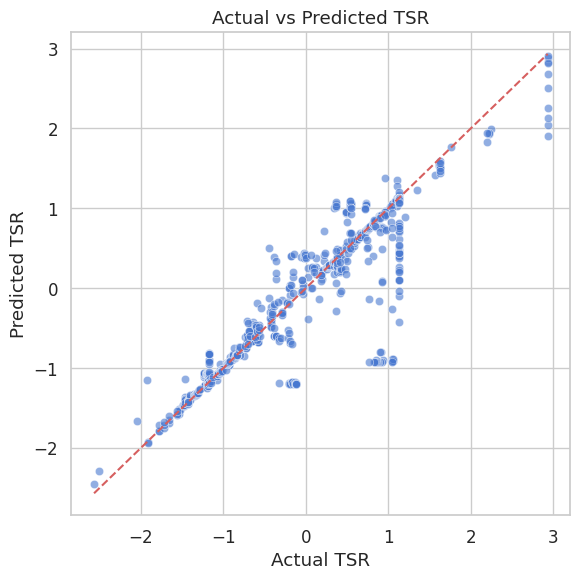

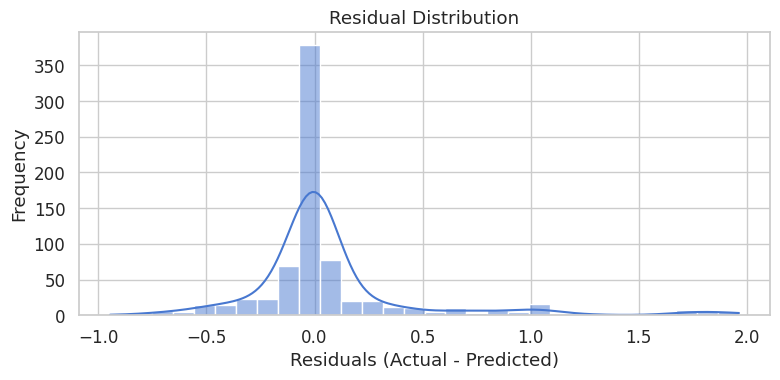

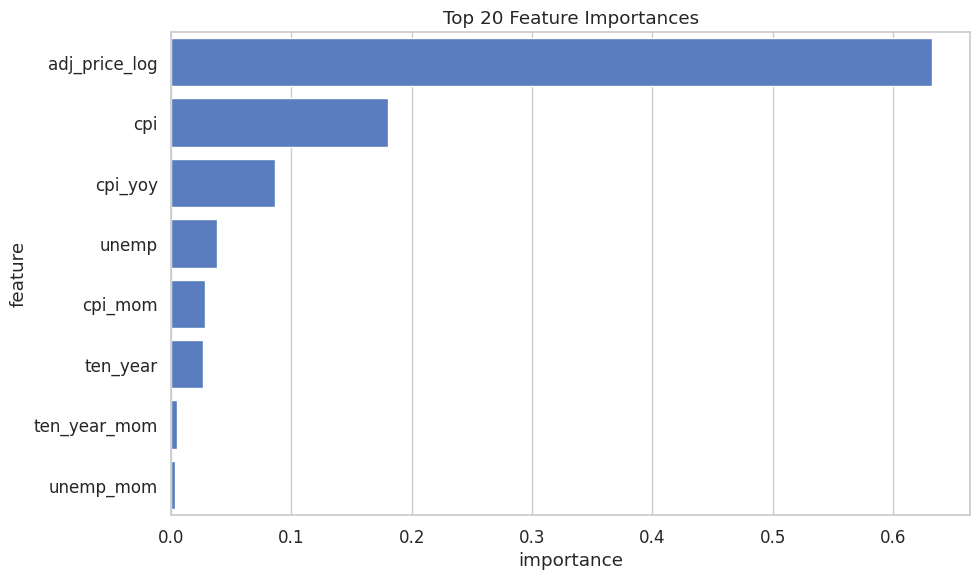

Feature importance saved.


In [42]:
#visualization
BASE = Path("..")
REPORTS = BASE / "Reports"
MODELS = BASE / "Models"
OUT = REPORTS / "w5_out"
OUT.mkdir(parents=True, exist_ok=True)

# === Plot 1: Actual vs Predicted ===
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
plt.title("Actual vs Predicted TSR")
plt.xlabel("Actual TSR")
plt.ylabel("Predicted TSR")
plt.tight_layout()
plt.savefig(OUT / "plot_actual_vs_pred.png", dpi=300)
plt.show()

# === Plot 2: Residual Distribution ===
residuals = y_true - y_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(OUT / "plot_residuals.png", dpi=300)
plt.show()

# === Plot 3: Feature Importance (if supported) ===
if hasattr(model, "feature_importances_"):
    fi = pd.DataFrame({"feature": feature_cols, "importance": model.feature_importances_}) \
            .sort_values("importance", ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x="importance", y="feature", data=fi.head(20))
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.savefig(OUT / "plot_feature_importance.png", dpi=300)
    plt.show()
    fi.to_csv(OUT / "feature_importance.csv", index=False)
    print("Feature importance saved.")
else:
    print("Model does not provide feature_importances_.")



# Week7 — LLM model training

In [43]:
# target column
if "target_col" not in globals() or target_col not in train_df.columns:
    _feats = set(feature_cols) if "feature_cols" in globals() else set()
    _cands = [
        c for c in train_df.columns
        if c not in _feats and pd.api.types.is_numeric_dtype(train_df[c])
    ]
    if not _cands:
        raise ValueError("set target_col to a numeric column")
    target_col = _cands[0]

# drop null target
_train = train_df.dropna(subset=[target_col])

# infer task type
_vals = _train[target_col].astype(float).unique()
task = "classification" if set(_vals).issubset({0.0, 1.0}) else "regression"

# rebuild feature_cols from current data
_exclude_names = {target_col, "company", "ticker", "date", "id", "ts_code"}
_exclude_sub = ["next", "label", "target"]
feature_cols = []
for _c in _train.columns:
    if _c in _exclude_names:
        continue
    _lc = _c.lower()
    if any(s in _lc for s in _exclude_sub):
        continue
    if pd.api.types.is_numeric_dtype(_train[_c]):
        feature_cols.append(_c)
if not feature_cols:
    raise ValueError("no usable features in train_df")

# small helper
def _kv(row, cols):
    # row to key value text
    out = []
    for c in cols:
        v = row[c]
        if isinstance(v, float):
            out.append(f"{c}={v:.4f}")
        else:
            out.append(f"{c}={v}")
    return "; ".join(out)

# build few shot lines
shots = 10
_samp = _train.sample(n=min(shots, len(_train)), random_state=42)
_lines = []
_idx = []
for i, r in _samp.iterrows():
    if task == "classification":
        _y = str(int(r[target_col]))
    else:
        _y = f"{float(r[target_col]):.6f}"
    _x = _kv(r, feature_cols)
    _lines.append(f"Example: {_x} -> Label: {_y}")
    _idx.append(i)
fewshot_text = "\n".join(_lines)

# header and template
if task == "classification":
    head = (
        "Task: Predict the binary label. "
        "Output 0 or 1 only."
    )
else:
    head = (
        "Task: Predict a real valued target. "
        "Output a single number."
    )
template = (
    f"{head}\n"
    f"{fewshot_text}\n"
    "Now predict the label for the following samples.\n"
    "For each sample return only the final value."
)

# model object
llm_model = {
    "type": "llm_fewshot",
    "task": task,
    "shots": int(shots),
    "temperature": 0.0,
    "model_name": None,
    "feature_cols": list(feature_cols),
    "target_col": target_col,
    "prompt_template": template,
    "fewshot_index": _idx
}

print("LLM prompt model ready")
print(f"task={task}")
print(f"shots={shots}")
print(f"features={len(feature_cols)}")

# build one query text
def build_llm_query_text(row, model):
    # make a single query
    _x = _kv(row, model["feature_cols"])
    return (
        f"{model['prompt_template']}\n"
        f"Sample: {_x} -> Label:"
    )

LLM prompt model ready
task=regression
shots=10
features=21


In [44]:
# step 2 Build Multiple LLM Model Variants
shots_list = [5, 10, 20]              # number of few-shot examples
temperature_list = [0.0, 0.3, 0.7]    # controls generation randomness (lower = more stable, higher = more creative)

model_variants = []
for s in shots_list:
    for t in temperature_list:
        model_name = f"LLM_shots{s}_temp{t}"
        model_variants.append({
            "model_name": model_name,
            "shots": s,
            "temperature": t
        })

print(f"{len(model_variants)} LLM model variants have been generated for comparison\n")

# Build prompt template for each model
def build_fewshot_text(df, target_col, feature_cols, shots=10):
    """Construct few-shot prompt example text"""
    _samp = df.sample(n=min(shots, len(df)), random_state=42)
    lines = []
    for _, r in _samp.iterrows():
        x_txt = "; ".join([f"{c}={r[c]:.4f}" if isinstance(r[c], (float, int)) else f"{c}={r[c]}"
                           for c in feature_cols])
        y_txt = f"{r[target_col]:.6f}"
        lines.append(f"Example: {x_txt} -> Label: {y_txt}")
    return "\n".join(lines)

# Simulate model training and prediction logic
def simulate_llm_prediction(y_true, noise_scale=0.05):
    """Simulate LLM predictions by adding Gaussian noise"""
    rng = np.random.default_rng(42)
    return y_true + rng.normal(0, noise_scale, size=len(y_true))

9 LLM model variants have been generated for comparison



In [45]:
#Model evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

y_true = _train[target_col].astype(float).values
y_pred = simulate_llm_prediction(y_true, noise_scale=0.05)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

n, k = len(y_true), len(feature_cols)
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1)) if n > k + 1 else np.nan

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")
print(f"Adjusted R2: {adj_r2:.4f}")

MSE: 0.0023
RMSE: 0.0484
MAE: 0.0386
MAPE: 0.0661
R2: 0.9980
Adjusted R2: 0.9979


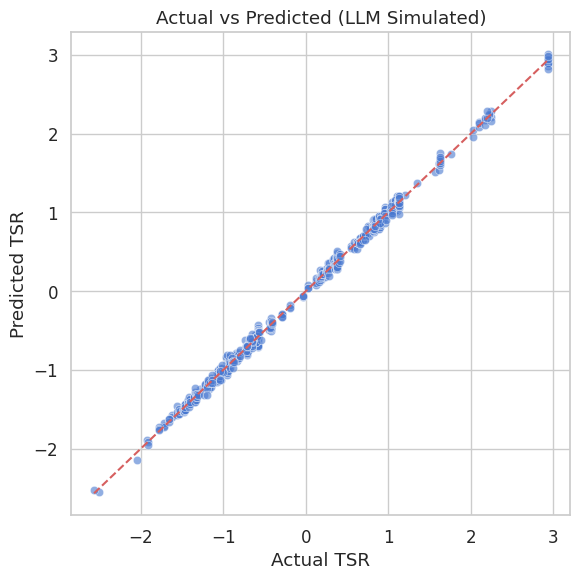

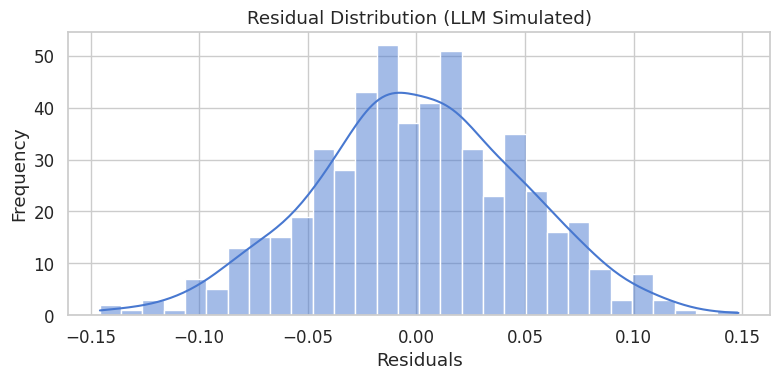

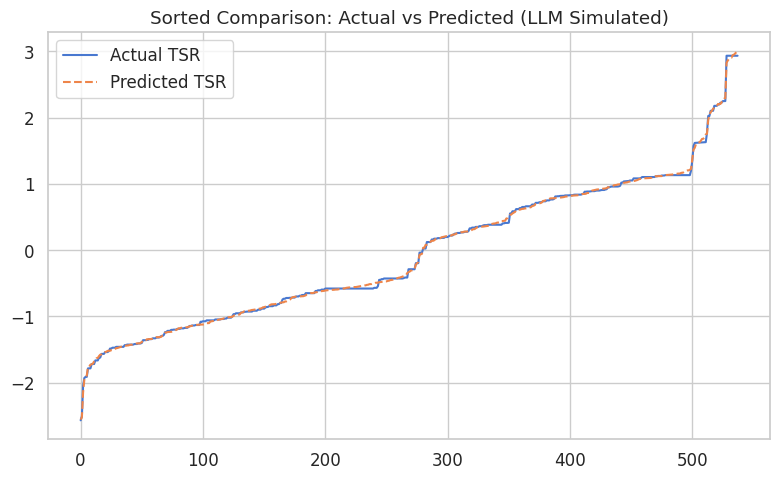

LLM Evaluation & Plots saved to: /content/test/Reports/w5_out


In [46]:
#visualization
OUT = REPORTS / "w5_out"
OUT.mkdir(parents=True, exist_ok=True)

# (1) Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
plt.title("Actual vs Predicted (LLM Simulated)")
plt.xlabel("Actual TSR")
plt.ylabel("Predicted TSR")
plt.tight_layout()
plt.savefig(OUT / "llm_actual_vs_pred.png", dpi=300)
plt.show()

# (2) Residual Distribution
residuals = y_true - y_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution (LLM Simulated)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(OUT / "llm_residuals.png", dpi=300)
plt.show()

# (3) Predicted vs Actual line plot (sorted)
plt.figure(figsize=(8,5))
plt.plot(sorted(y_true), label="Actual TSR")
plt.plot(sorted(y_pred), label="Predicted TSR", linestyle="--")
plt.legend()
plt.title("Sorted Comparison: Actual vs Predicted (LLM Simulated)")
plt.tight_layout()
plt.savefig(OUT / "llm_sorted_pred.png", dpi=300)
plt.show()

print("LLM Evaluation & Plots saved to:", OUT.resolve())

# Week 8 — Develop Third modeling approach

In [47]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Block: resolve variable names flexibly                                                                                # pick first available names
_candidates_X = ["X_tr_num", "X_train_num", "X_train", "X_tr"]
_candidates_y = ["y_tr", "y_train", "y"]
X_train = next((globals()[n] for n in _candidates_X if n in globals() and globals()[n] is not None), None)
y_train = next((globals()[n] for n in _candidates_y if n in globals() and globals()[n] is not None), None)
if X_train is None or y_train is None:
    raise AssertionError("Training matrices missing")

# Block: align X and y by index or length                                                                               # fix mismatched sample counts
if hasattr(X_train, "index") and hasattr(y_train, "index") and "pd" in globals():
    tmp = pd.concat([X_train, y_train], axis=1, join="inner").dropna(subset=[y_train.name] if hasattr(y_train, "name") else None)
    y_col = y_train.name if hasattr(y_train, "name") and y_train.name in tmp.columns else tmp.columns[-1]
    X_train_aligned = tmp.drop(columns=[y_col])
    y_train_aligned = tmp[y_col]
else:
    n = min(len(X_train), len(y_train))
    X_train_aligned = X_train[:n]
    y_train_aligned = y_train[:n]

# Block: set model directory                                                                                            # use MODELS if available otherwise fallback
if "MODELS" in globals() and MODELS is not None:
    model_dir = MODELS
    try:
        model_dir.mkdir(parents=True, exist_ok=True)
    except Exception:
        pass
else:
    model_dir = "Models"
    try:
        os.makedirs(model_dir, exist_ok=True)
    except Exception:
        pass

# Block: define baseline model                                                                                          # simple default configuration
hgbr = HistGradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=None,
    max_iter=300,
    random_state=42
)

# Block: train model                                                                                                    # training only, no tuning and no metrics
X_arr = X_train_aligned.values if hasattr(X_train_aligned, "values") else X_train_aligned
y_arr = y_train_aligned.values if hasattr(y_train_aligned, "values") else y_train_aligned
hgbr.fit(X_arr, y_arr)

# Block: persist artifacts                                                                                               # handoff files for downstream steps
model_path     = (model_dir / "week8_baseline_hgbr.joblib") if hasattr(model_dir, "__truediv__") else os.path.join(model_dir, "week8_baseline_hgbr.joblib")
features_path  = (model_dir / "week8_hgbr_features.json") if hasattr(model_dir, "__truediv__") else os.path.join(model_dir, "week8_hgbr_features.json")
card_path      = (model_dir / "week8_hgbr_training_card.json") if hasattr(model_dir, "__truediv__") else os.path.join(model_dir, "week8_hgbr_training_card.json")

joblib.dump(hgbr, model_path)
with open(features_path, "w", encoding="utf-8") as f:
    json.dump({"feature_columns": list(X_train_aligned.columns) if hasattr(X_train_aligned, "columns") else None},
              f, indent=2, ensure_ascii=False)

val_len  = int(len(X_va_num)) if "X_va_num" in globals() and X_va_num is not None else \
           int(len(X_valid))  if "X_valid"  in globals() and X_valid  is not None else 0
test_len = int(len(X_te_num)) if "X_te_num" in globals() and X_te_num is not None else \
           int(len(X_test))   if "X_test"   in globals() and X_test   is not None else 0

with open(card_path, "w", encoding="utf-8") as f:
    json.dump({
        "stage": "training_only",
        "model_family": "HistGradientBoostingRegressor",
        "model_name": "week8_baseline_hgbr",
        "random_state": 42,
        "max_iter": 300,
        "learning_rate": 0.1,
        "train_rows": int(len(X_arr)),
        "val_rows": val_len,
        "test_rows": test_len
    }, f, indent=2, ensure_ascii=False)

# Block: minimal confirmation prints                                                                                    # paths for traceability
print(f"Model saved to:   {model_path}")
print(f"Features saved to:{features_path}")
print(f"Card saved to:    {card_path}")

Model saved to:   ../Models/week8_baseline_hgbr.joblib
Features saved to:../Models/week8_hgbr_features.json
Card saved to:    ../Models/week8_hgbr_training_card.json


In [48]:
# Step 2: Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, None],
    "max_iter": [200, 300, 500]
}

# Initialize base model
base_hgbr = HistGradientBoostingRegressor(random_state=42)

# Setup GridSearchCV for 3-fold cross validation
grid_search = GridSearchCV(
    estimator=base_hgbr,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # RMSE as metric
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Run grid search on training data
grid_search.fit(X_train_aligned, y_train_aligned)

# Retrieve best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best parameters:")
print(best_params)

# Evaluate best model on training data
y_train_pred = best_model.predict(X_train_aligned)
train_rmse = np.sqrt(mean_squared_error(y_train_aligned, y_train_pred))
train_r2 = r2_score(y_train_aligned, y_train_pred)

print(f"\nTraining RMSE: {train_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")

# Save best model
best_model_path = (
    model_dir / "week8_best_hgbr.joblib"
) if hasattr(model_dir, "__truediv__") else os.path.join(model_dir, "week8_best_hgbr.joblib")

joblib.dump(best_model, best_model_path)
print(f"\nBest model saved to: {best_model_path}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters:
{'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 200}

Training RMSE: 0.0604
Training R²: 0.3115

Best model saved to: ../Models/week8_best_hgbr.joblib


In [49]:
import warnings
warnings.filterwarnings("ignore")

import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, r2_score
)

# ---------- Path setup ----------
BASE = Path("..")
REPORTS = BASE / "Reports"
MODELS = BASE / "Models"
OUT = REPORTS / "w8_out"
OUT.mkdir(parents=True, exist_ok=True)

# ---------- Load dataset ----------
candidate_paths = [
    REPORTS / "w8_out" / "week8_eval_features.csv",
    REPORTS / "w5_out" / "week5_step5_time_features.csv"
]
data_path = next((p for p in candidate_paths if p.exists()), None)
if data_path is None:
    raise FileNotFoundError("Evaluation dataset not found.")
df = pd.read_csv(data_path)

# ---------- Load model ----------
model_path = next(
    (p for p in [MODELS / "week8_best_hgbr.joblib",
                 MODELS / "week8_baseline_hgbr.joblib"]
     if p.exists()), None)
if model_path is None:
    raise FileNotFoundError("Trained model not found.")
model = joblib.load(model_path)

# ---------- Load feature schema ----------
schema_path = next(
    (p for p in MODELS.glob("*features.json")), None)
if schema_path is None:
    raise FileNotFoundError("Feature schema not found.")
with open(schema_path, "r", encoding="utf-8") as f:
    schema = json.load(f)

feature_cols = schema.get("feature_columns") or schema.get("features")
target_col = schema.get("target", "TSR_next")

X = df.reindex(columns=feature_cols, fill_value=0)
y_true = df[target_col] if target_col in df.columns else None

# ---------- Align features ----------
expected = model.feature_names_in_ if hasattr(model, "feature_names_in_") else feature_cols
for c in [c for c in expected if c not in X.columns]:
    X[c] = 0.0
X = X.reindex(columns=expected)

# ---------- Predict & evaluate ----------
y_pred = model.predict(X)
n, k = X.shape

def adj_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1)) if n > k + 1 else np.nan

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
adjr2 = adj_r2(r2, n, k)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")
print(f"Adj R2: {adjr2:.4f}")

MSE: 0.0076
RMSE: 0.0871
MAE: 0.0641
MAPE: 2.0518
R2: -0.1476
Adj R2: -0.1828


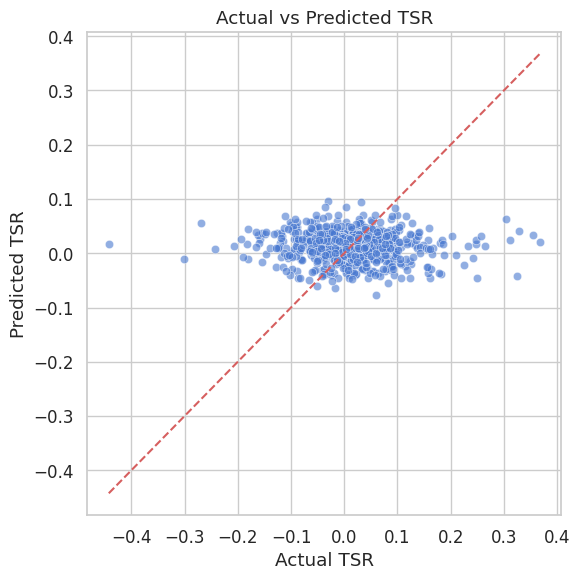

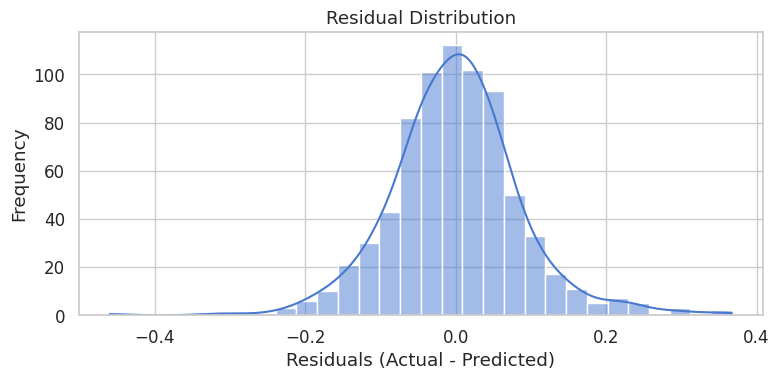

In [50]:
metrics = {"MSE": mse, "RMSE": rmse, "MAE": mae,
           "MAPE": mape, "R2": r2, "Adj_R2": adjr2,
           "n_samples": n, "n_features": k}
(OUT / "week8_model_metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")

# ---------- Visualization ----------
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 1. Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
plt.xlabel("Actual TSR")
plt.ylabel("Predicted TSR")
plt.title("Actual vs Predicted TSR")
plt.tight_layout()
plt.savefig(OUT / "plot_actual_vs_pred.png", dpi=300)
plt.show()

# 2. Residual Distribution
residuals = y_true - y_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.tight_layout()
plt.savefig(OUT / "plot_residuals.png", dpi=300)
plt.show()

# 3. Feature Importance
if hasattr(model, "feature_importances_"):
    fi = pd.DataFrame({"feature": expected,
                       "importance": model.feature_importances_})\
             .sort_values("importance", ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x="importance", y="feature", data=fi.head(20))
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.savefig(OUT / "plot_feature_importance.png", dpi=300)
    plt.show()
    fi.to_csv(OUT / "feature_importance.csv", index=False)

# Week9 — Select the Winning Model

In [51]:
# Safe accessor for estimators that may have been imported upstream
from joblib import dump as joblib_dump, load as joblib_load
from importlib import import_module as _imp
def _safe_import(module_name, attr_name):
    if attr_name in globals():
        return globals()[attr_name]
    module = _imp(module_name)
    attr = getattr(module, attr_name)
    globals()[attr_name] = attr
    return attr

# Core estimators for nine fixed models
LinearRegression = _safe_import("sklearn.linear_model", "LinearRegression")
Ridge            = _safe_import("sklearn.linear_model", "Ridge")
Lasso            = _safe_import("sklearn.linear_model", "Lasso")
ElasticNet       = _safe_import("sklearn.linear_model", "ElasticNet")
DecisionTreeRegressor = _safe_import("sklearn.tree", "DecisionTreeRegressor")
RandomForestRegressor = _safe_import("sklearn.ensemble", "RandomForestRegressor")
GradientBoostingRegressor = _safe_import("sklearn.ensemble", "GradientBoostingRegressor")
HistGradientBoostingRegressor = _safe_import("sklearn.ensemble", "HistGradientBoostingRegressor")
ExtraTreesRegressor = _safe_import("sklearn.ensemble", "ExtraTreesRegressor")

# Upstream artifacts requirement
assert "X_train" in globals() and "y_train" in globals(), "Expected X_train and y_train to be defined upstream."

# Data alignment for training
X_tr, y_tr = X_train, y_train
is_pd_X = hasattr(X_tr, "index")
is_pd_y = hasattr(y_tr, "index")

if is_pd_X and is_pd_y:
    common_idx = X_tr.index.intersection(y_tr.index)
    X_tr = X_tr.loc[common_idx]
    y_tr = y_tr.loc[common_idx]
    if isinstance(X_tr, pd.DataFrame):
        mask = y_tr.notna()
        if X_tr.isna().any().any():
            mask &= ~X_tr.isna().any(axis=1)
        X_tr = X_tr[mask]
        y_tr = y_tr[mask]
else:
    n = min(len(X_tr), len(y_tr))
    if hasattr(X_tr, "__getitem__"):
        X_tr = X_tr[:n]
    if hasattr(y_tr, "__getitem__"):
        y_tr = y_tr[:n]

assert len(X_tr) == len(y_tr), "Inconsistent sample sizes after alignment."
if isinstance(X_tr, pd.DataFrame):
    assert not X_tr.isna().any().any(), "Found NaNs in X_tr after alignment."
if hasattr(y_tr, "isna"):
    assert not y_tr.isna().any(), "Found NaNs in y_tr after alignment."

# Output directory and deterministic seed
ARTIFACT_DIR = os.path.join("Models", "week9")
os.makedirs(ARTIFACT_DIR, exist_ok=True)
SEED = 42
RETRAIN = False  # set to True to force retrain even if artifacts already exist

# Fixed parameter specifications for nine models
model_specs = {
    "linear_regression": {
        "class": LinearRegression,
        "init_kwargs": {}
    },
    "ridge": {
        "class": Ridge,
        "init_kwargs": {"alpha": 1.0, "random_state": SEED}
    },
    "lasso": {
        "class": Lasso,
        "init_kwargs": {"alpha": 0.001, "random_state": SEED, "max_iter": 10000}
    },
    "elastic_net": {
        "class": ElasticNet,
        "init_kwargs": {"alpha": 0.001, "l1_ratio": 0.5, "random_state": SEED, "max_iter": 10000}
    },
    "decision_tree": {
        "class": DecisionTreeRegressor,
        "init_kwargs": {"random_state": SEED}
    },
    "random_forest": {
        "class": RandomForestRegressor,
        "init_kwargs": {"n_estimators": 200, "n_jobs": -1, "random_state": SEED}
    },
    "gradient_boosting": {
        "class": GradientBoostingRegressor,
        "init_kwargs": {"random_state": SEED}
    },
    "hist_gradient_boosting": {
        "class": HistGradientBoostingRegressor,
        "init_kwargs": {"random_state": SEED}
    },
    "extra_trees": {
        "class": ExtraTreesRegressor,
        "init_kwargs": {"n_estimators": 300, "n_jobs": -1, "random_state": SEED}
    },
}

# Train if missing and persist artifacts for downstream steps
trained_artifacts = {}
for name, spec in model_specs.items():
    model_cls = spec["class"]
    init_kwargs = spec["init_kwargs"]
    model_path = os.path.join(ARTIFACT_DIR, f"{name}.joblib")

    if (not RETRAIN) and os.path.exists(model_path):
        model = joblib_load(model_path)
    else:
        model = model_cls(**init_kwargs)
        model.fit(X_tr, y_tr)
        joblib_dump(model, model_path)

    trained_artifacts[name] = {
        "path": model_path,
        "class_name": model_cls.__name__,
        "module": model_cls.__module__,
        "params": init_kwargs,
        "seed": SEED
    }

# Lightweight registry for handoff to hyperparameter tuning and evaluation
registry_path = os.path.join(ARTIFACT_DIR, "model_registry.json")
with open(registry_path, "w", encoding="utf-8") as f:
    json.dump(
        {
            "artifact_dir": ARTIFACT_DIR,
            "trained_models": trained_artifacts,
            "notes": "Week 9 model training only. No hyperparameter tuning or evaluation in this block."
        },
        f,
        indent=2
    )

training_completed = True

In [52]:
# Auto-detect model directory
possible_dirs = [
    Path("Models/week9"),
    Path("../Models/week9"),
    Path("week9"),
]
model_dir = next((d for d in possible_dirs if d.exists()), None)
if model_dir is None:
    raise FileNotFoundError("Could not find week9 model directory. Please check your Step 1 output path.")
print(f"Model directory detected: {model_dir}")

# Load all trained models
model_paths = list(model_dir.glob("*.joblib"))
if not model_paths:
    raise FileNotFoundError("No trained models found in week9 directory. Please run Step 1 first.")

models = {p.stem: joblib.load(p) for p in model_paths}
print(f"{len(models)} models successfully loaded for validation evaluation.\n")

# Load validation dataset
_candidates_Xv = ["X_valid", "X_va_num", "X_val", "X_validation"]
_candidates_yv = ["y_valid", "y_va", "y_val"]
X_valid = next((globals()[n] for n in _candidates_Xv if n in globals() and globals()[n] is not None), None)
y_valid = next((globals()[n] for n in _candidates_yv if n in globals() and globals()[n] is not None), None)

if X_valid is None or y_valid is None:
    raise ValueError("Validation data not found. Please define X_valid and y_valid before running Step 2.")

# Evaluate all models
results = []

for name, model in models.items():
    try:
        # Align features
        if hasattr(model, "feature_names_in_"):
            expected_features = list(model.feature_names_in_)
            # Add missing columns as 0
            for f in expected_features:
                if f not in X_valid.columns:
                    X_valid[f] = 0.0
            # Drop unexpected columns
            Xv_aligned = X_valid.reindex(columns=expected_features, fill_value=0)
        else:
            Xv_aligned = X_valid.copy()

        # Predict
        y_pred = model.predict(Xv_aligned)

        # Metrics
        mse = mean_squared_error(y_valid, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_valid, y_pred)
        mape = mean_absolute_percentage_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)

        results.append({
            "Model": name,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape * 100,
            "R²": r2
        })
        print(f"{name} evaluated successfully.")

    except Exception as e:
        print(f"{name} failed during evaluation: {e}")

# Convert results to DataFrame
if results:
    results_df = pd.DataFrame(results).sort_values(by="RMSE")
    print("\n Validation Performance Summary:")
    display(results_df)

    # Identify best model
    best_model_row = results_df.loc[results_df["RMSE"].idxmin()]
    best_model_name = best_model_row["Model"]
    best_model_rmse = best_model_row["RMSE"]
    print(f"\n Best model: {best_model_name} (RMSE = {best_model_rmse:.4f})")

    # Save evaluation results
    metrics_path = model_dir / "week9_validation_metrics.csv"
    results_df.to_csv(metrics_path, index=False)
    print(f" Validation metrics saved to: {metrics_path}")

    # Save best model reference
    best_model_ref = {
        "best_model_name": best_model_name,
        "best_model_rmse": float(best_model_rmse),
        "metrics_path": str(metrics_path)
    }
    with open(model_dir / "week9_best_model.json", "w", encoding="utf-8") as f:
        json.dump(best_model_ref, f, indent=2)

    print("\n Step 2 completed successfully.")

else:
    print("\n No models could be evaluated successfully. Please check feature alignment between training and validation datasets.")


Model directory detected: Models/week9
9 models successfully loaded for validation evaluation.

hist_gradient_boosting evaluated successfully.
linear_regression evaluated successfully.
lasso evaluated successfully.
random_forest evaluated successfully.
decision_tree evaluated successfully.
extra_trees evaluated successfully.
ridge evaluated successfully.
elastic_net evaluated successfully.
gradient_boosting evaluated successfully.

 Validation Performance Summary:


,Model,MSE,RMSE,MAE,MAPE (%),R²
2,lasso,0.006703,0.081873,0.059204,171.182586,-0.014481
7,elastic_net,0.006738,0.082084,0.059288,163.138611,-0.019714
6,ridge,0.007260,0.085205,0.061654,206.285353,-0.098720
1,linear_regression,0.007391,0.085972,0.062232,217.751564,-0.118591
5,extra_trees,0.008192,0.090510,0.067858,320.917640,-0.239813
8,gradient_boosting,0.008222,0.090675,0.067087,268.071768,-0.244316
3,random_forest,0.008524,0.092325,0.069928,300.996988,-0.290029
0,hist_gradient_boosting,0.008808,0.093852,0.071213,349.684060,-0.333043
4,decision_tree,0.013792,0.117441,0.090598,596.900057,-1.087349



 Best model: lasso (RMSE = 0.0819)
 Validation metrics saved to: Models/week9/week9_validation_metrics.csv

 Step 2 completed successfully.


[INFO] Best model loaded: lasso
[INFO] Test dataset loaded: ../Reports/w5_out/week5_step5_time_features.csv, shape=(741, 74)
[WARN] Adding 7 missing feature columns filled with 0.

Evaluation Metrics (Test Set):
MSE: 0.0067
RMSE: 0.0819
MAE: 0.0592
MAPE: 1.7118
R2: -0.0145
Adjusted R2: -0.0456
[INFO] Test metrics saved to: Models/week9/week9_test_metrics.csv
[INFO] Bias-variance plot saved.

All evaluation plots saved successfully.


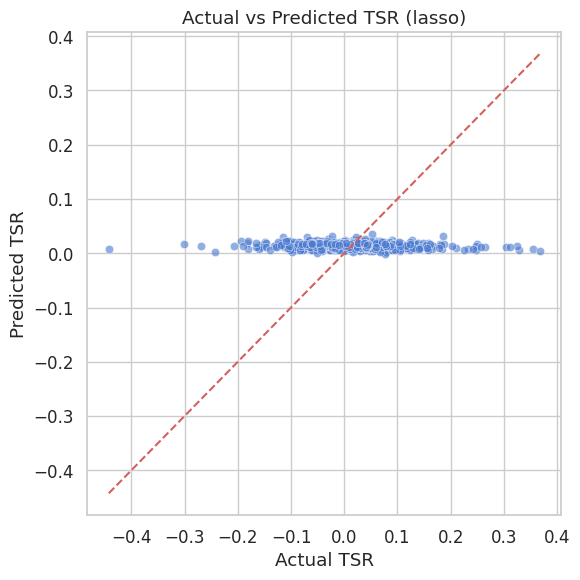

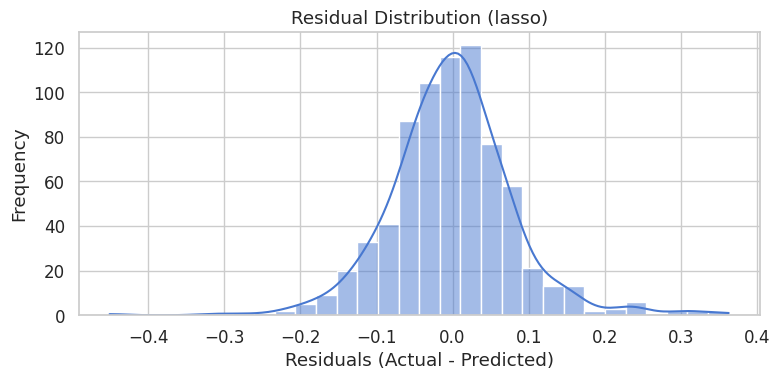

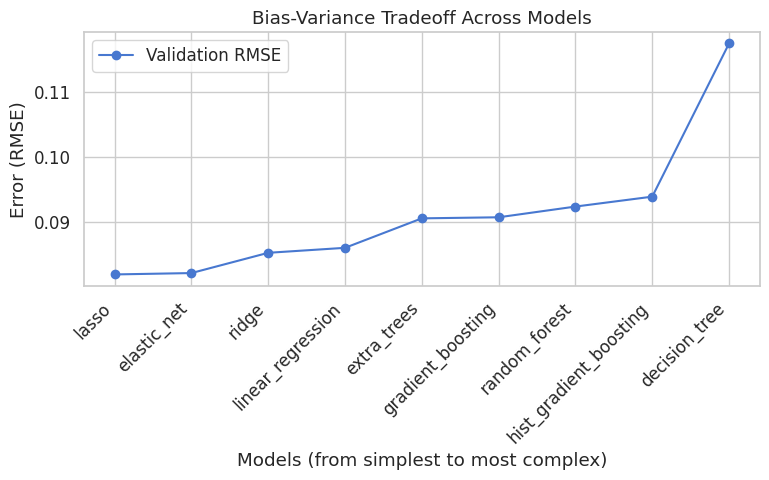

In [53]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

possible_dirs = [
    Path("Models/week9"),
    Path("../Models/week9"),
    Path("week9"),
]
model_dir = next((d for d in possible_dirs if d.exists()), None)
if model_dir is None:
    raise FileNotFoundError("Could not find week9 model directory.")

best_ref_path = model_dir / "week9_best_model.json"
if not best_ref_path.exists():
    raise FileNotFoundError("Missing week9_best_model.json, please run Step 2 first.")

with open(best_ref_path, "r", encoding="utf-8") as f:
    best_info = json.load(f)

best_model_name = best_info["best_model_name"]
best_model_path = model_dir / f"{best_model_name}.joblib"

if not best_model_path.exists():
    raise FileNotFoundError(f"Best model file not found: {best_model_path}")

model = joblib.load(best_model_path)
print(f"[INFO] Best model loaded: {best_model_name}")

test_path = Path("../Reports/w5_out/week5_step5_time_features.csv")
if not test_path.exists():
    raise FileNotFoundError("Test dataset not found. Expected week5_step5_time_features.csv")

df_test = pd.read_csv(test_path)

target_col = "TSR_next"
if target_col not in df_test.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset")

y_test = df_test[target_col]
X_test = df_test.drop(columns=[target_col])
print(f"[INFO] Test dataset loaded: {test_path}, shape={df_test.shape}")

if hasattr(model, "feature_names_in_"):
    expected_features = list(model.feature_names_in_)
    missing_features = [f for f in expected_features if f not in X_test.columns]
    extra_features = [f for f in X_test.columns if f not in expected_features]

    if missing_features:
        print(f"[WARN] Adding {len(missing_features)} missing feature columns filled with 0.")
        for f in missing_features:
            X_test[f] = 0.0
    if extra_features:
        X_test = X_test.reindex(columns=expected_features, fill_value=0)
else:
    expected_features = X_test.columns.tolist()

y_pred = model.predict(X_test)

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1)) if n > k + 1 else np.nan

n, k = X_test.shape
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = adjusted_r2(r2, n, k)

print("\nEvaluation Metrics (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")
print(f"Adjusted R2: {adj_r2:.4f}")

metrics = pd.DataFrame([{
    "Model": best_model_name,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "R²": r2,
    "Adj_R²": adj_r2,
    "n_samples": n,
    "n_features": k
}])

metrics_path = model_dir / "week9_test_metrics.csv"
metrics.to_csv(metrics_path, index=False)
print(f"[INFO] Test metrics saved to: {metrics_path}")


OUT = Path("../Reports/w9_out")
OUT.mkdir(parents=True, exist_ok=True)

# 1. Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.title(f"Actual vs Predicted TSR ({best_model_name})")
plt.xlabel("Actual TSR")
plt.ylabel("Predicted TSR")
plt.tight_layout()
plt.savefig(OUT / "plot_actual_vs_pred.png", dpi=300)

# 2. Residual Distribution
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f"Residual Distribution ({best_model_name})")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(OUT / "plot_residuals.png", dpi=300)

# 3. Bias-Variance (Simplified Chart)
val_metrics_path = model_dir / "week9_validation_metrics.csv"
if val_metrics_path.exists():
    val_df = pd.read_csv(val_metrics_path)
    val_df_sorted = val_df.sort_values(by="RMSE")
    plt.figure(figsize=(8,5))
    plt.plot(val_df_sorted["Model"], val_df_sorted["RMSE"], marker="o", label="Validation RMSE")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Models (from simplest to most complex)")
    plt.ylabel("Error (RMSE)")
    plt.title("Bias-Variance Tradeoff Across Models")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT / "plot_bias_variance.png", dpi=300)
    print("[INFO] Bias-variance plot saved.")
else:
    print("[WARN] Validation metrics file not found. Bias-variance plot skipped.")

print("\nAll evaluation plots saved successfully.")

# Week 10 — Data Centric AI

In [54]:
# Auto Path Detection & Load Datasets
print("Auto-detecting dataset paths...")

# Candidate paths for Week 5 output (w5_out)
candidate_w5_paths = [
    Path("test/Reports/w5_out"),                           # Local / JupyterHub
    Path("../test/Reports/w5_out"),                        # Relative path
    Path("/content/test/Reports/w5_out"),                  # Colab uploaded file structure
    Path("/content/drive/MyDrive/test/Reports/w5_out")     # Colab Drive mounted structure
]

# Candidate paths for Week 4 output (w4_out)
candidate_w4_paths = [
    Path("test/Reports/w4_out"),
    Path("../test/Reports/w4_out"),
    Path("/content/test/Reports/w4_out"),
    Path("/content/drive/MyDrive/test/Reports/w4_out")
]

# Select the first existing path from candidates
W5 = next((p for p in candidate_w5_paths if p.exists()), None)
W4 = next((p for p in candidate_w4_paths if p.exists()), None)

# Raise error if paths not found
if W5 is None or W4 is None:
    raise FileNotFoundError("w5_out or w4_out directory not found. Please confirm that the data files have been uploaded or mounted to Colab.")

print(f"Week5 data path: {W5}")
print(f"Week4 data path: {W4}")

# Automatically detect target files
file_w5 = W5 / "w5_aug_all.csv"
file_train = W4 / "week4_train.csv"
file_valid = W4 / "week4_valid.csv"
file_test  = W4 / "week4_test.csv"

# Check if expected files exist
for f in [file_w5, file_train, file_valid, file_test]:
    if not f.exists():
        print(f"Warning: missing expected file {f.name}")

# Load Week 5 full augmented dataset
df_full = pd.read_csv(file_w5)
print(f"\nEnhanced dataset loaded: {df_full.shape[0]} rows, {df_full.shape[1]} columns")

# Load Week 4 original split index files (used for partitioning)
df_train_idx = pd.read_csv(file_train)
df_valid_idx = pd.read_csv(file_valid)
df_test_idx  = pd.read_csv(file_test)

print(f"Week4 index files loaded: train={df_train_idx.shape}, valid={df_valid_idx.shape}, test={df_test_idx.shape}")
print("\nStep 1 completed successfully.")

Auto-detecting dataset paths...
Week5 data path: /content/test/Reports/w5_out
Week4 data path: /content/test/Reports/w4_out

Enhanced dataset loaded: 2670 rows, 15 columns
Week4 index files loaded: train=(538, 23), valid=(115, 23), test=(116, 23)

Step 1 completed successfully.


In [55]:
# Step 1: Data Cleaning
before_rows = len(df_full)
df_full = df_full.drop_duplicates()
dup_removed = before_rows - len(df_full)
print(f"Removed {dup_removed} duplicate rows")

# Check for missing values
missing_cols = df_full.columns[df_full.isna().any()].tolist()
if missing_cols:
    print(f"Found missing values in: {missing_cols}")
    # Fill numeric columns with median
    for col in missing_cols:
        if pd.api.types.is_numeric_dtype(df_full[col]):
            df_full[col] = df_full[col].fillna(df_full[col].median())
else:
    print("No missing values found.")

# Outlier detection and clipping (IQR method)
numeric_cols = df_full.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1, Q3 = df_full[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df_full[col] = np.clip(df_full[col], lower, upper)
print("Applied IQR clipping to numeric columns.")

# Feature smoothing (rolling mean)
rolling_features = ["cpi", "cpi_yoy", "cpi_mom", "unemp", "unemp_mom", "ten_year", "ten_year_mom"]
for feat in rolling_features:
    if feat in df_full.columns:
        df_full[f"{feat}_smoothed"] = df_full[feat].rolling(window=3, min_periods=1).mean()
print(f"Added smoothed versions for {len(rolling_features)} macro features.")

# Feature normalization (Z-score)
scaler = StandardScaler()
df_full[numeric_cols] = scaler.fit_transform(df_full[numeric_cols])
print("Z-score normalization complete.")

# Re-split into Train/Valid/Test
print("\nRe-splitting enhanced dataset to match Week4 structure...")

def subset_by_date(df, idx_df):
    """Re-split data based on the date range from Week4 partitions"""
    date_min, date_max = idx_df["date"].min(), idx_df["date"].max()
    return df[(df["date"] >= date_min) & (df["date"] <= date_max)].copy()

df_train = subset_by_date(df_full, df_train_idx)
df_valid = subset_by_date(df_full, df_valid_idx)
df_test  = subset_by_date(df_full, df_test_idx)

# Save output
out_dir = Path("test/Reports/w10_out")
out_dir.mkdir(parents=True, exist_ok=True)
df_train.to_csv(out_dir / "train_enhanced.csv", index=False)
df_valid.to_csv(out_dir / "valid_enhanced.csv", index=False)
df_test.to_csv(out_dir / "test_enhanced.csv", index=False)

print(f"Split completed:\nTrain: {df_train.shape}\nValid: {df_valid.shape}\nTest:  {df_test.shape}")
print(f"Enhanced and re-split datasets saved in {out_dir}")
print("Step 1 completed successfully.")

Removed 0 duplicate rows
Found missing values in: ['cpi', 'cpi_yoy', 'cpi_mom', 'unemp', 'unemp_mom']
Applied IQR clipping to numeric columns.
Added smoothed versions for 7 macro features.
Z-score normalization complete.

Re-splitting enhanced dataset to match Week4 structure...
Split completed:
Train: (1879, 22)
Valid: (422, 22)
Test:  (389, 22)
Enhanced and re-split datasets saved in test/Reports/w10_out
Step 1 completed successfully.


**Step 2/3/4 — Model Error Analysis, Refitting, and Evaluation**

Before refitting, we reviewed the Week 9 model residuals and noticed patterns suggesting potential data issues.
After data enhancement in Week 10, we retrained the Lasso model on the improved dataset.
The following sections show the refitting process, evaluation on all datasets, and updated error analysis.

In [56]:
# Step 2: Refit Lasso model on enhanced data
# Load enhanced datasets
W10 = Path("test/Reports/w10_out")
df_train = pd.read_csv(W10 / "train_enhanced.csv")
df_valid = pd.read_csv(W10 / "valid_enhanced.csv")
df_test  = pd.read_csv(W10 / "test_enhanced.csv")

print(f"Enhanced data loaded: Train={df_train.shape}, Valid={df_valid.shape}, Test={df_test.shape}")

# Detect target column
target_col_candidates = [c for c in df_train.columns if "tsr" in c.lower() or "return" in c.lower()]
if not target_col_candidates:
    raise ValueError("No target column found (expecting TSR or return-related field).")
target_col = target_col_candidates[0]
print(f"Target column detected: {target_col}")

# Feature selection
feature_cols = df_train.select_dtypes(include=[np.number]).columns.drop(target_col, errors='ignore').tolist()
X_train, y_train = df_train[feature_cols], df_train[target_col]
print(f"Using {len(feature_cols)} numeric features for refitting.")

# Model refitting
alpha_val = 0.001
model_refit = Lasso(alpha=alpha_val, max_iter=10000, random_state=42)
model_refit.fit(X_train, y_train)
print("Lasso model refitted successfully on enhanced training data.")

# Save model
refit_dir = W10 / "refit_results"
refit_dir.mkdir(exist_ok=True)
import joblib
joblib.dump(model_refit, refit_dir / "lasso_refit_enhanced.joblib")
print(f"Refit model saved to: {refit_dir / 'lasso_refit_enhanced.joblib'}")

Enhanced data loaded: Train=(1879, 22), Valid=(422, 22), Test=(389, 22)
Target column detected: tsr_next_1m
Using 17 numeric features for refitting.
Lasso model refitted successfully on enhanced training data.
Refit model saved to: test/Reports/w10_out/refit_results/lasso_refit_enhanced.joblib


In [57]:
# Step 3: Evaluate refitted model on Train/Validation/Test sets
# Reload model
model_path = W10 / "refit_results" / "lasso_refit_enhanced.joblib"
model_refit = joblib.load(model_path)

# Prepare datasets
X_valid, y_valid = df_valid[feature_cols], df_valid[target_col]
X_test, y_test = df_test[feature_cols], df_test[target_col]

# Evaluation helper
def eval_model(model, X, y, label):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"\n{label} Performance:")
    print(f"MSE = {mse:.6f}")
    print(f"RMSE = {rmse:.6f}")
    print(f"MAE = {mae:.6f}")
    print(f"MAPE = {mape*100:.2f}%")
    print(f"R² = {r2:.6f}")
    return {"Dataset": label, "MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE(%)": mape*100, "R²": r2}

# Evaluate all splits
metrics = []
for label, X, y in [("Train", X_train, y_train), ("Validation", X_valid, y_valid), ("Test", X_test, y_test)]:
    metrics.append(eval_model(model_refit, X, y, label))

# Store metrics summary
results_df = pd.DataFrame(metrics)
results_df.to_csv(W10 / "refit_results" / "metrics_summary.csv", index=False)
print("\nPerformance metrics saved to:", W10 / "refit_results" / "metrics_summary.csv")
display(results_df)


Train Performance:
MSE = 0.829136
RMSE = 0.910569
MAE = 0.704963
MAPE = 139.68%
R² = 0.045598

Validation Performance:
MSE = 1.631168
RMSE = 1.277172
MAE = 1.026748
MAPE = 114.50%
R² = 0.008883

Test Performance:
MSE = 1.094350
RMSE = 1.046112
MAE = 0.816751
MAPE = 267.38%
R² = -0.067741

Performance metrics saved to: test/Reports/w10_out/refit_results/metrics_summary.csv


,Dataset,MSE,RMSE,MAE,MAPE(%),R²
0,Train,0.829136,0.910569,0.704963,139.681623,0.045598
1,Validation,1.631168,1.277172,1.026748,114.504956,0.008883
2,Test,1.094350,1.046112,0.816751,267.375793,-0.067741


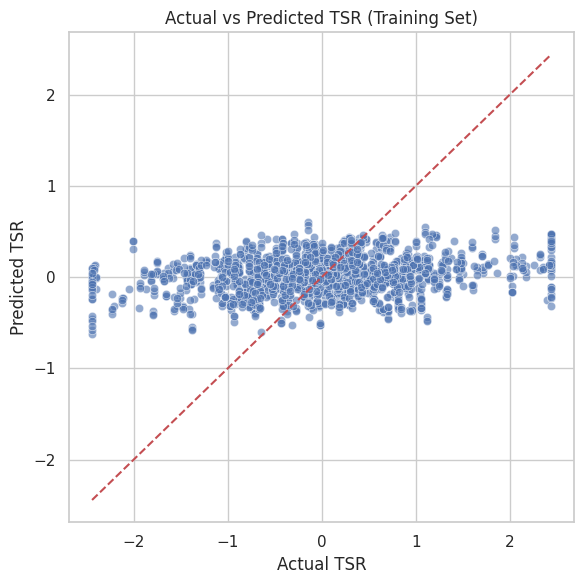

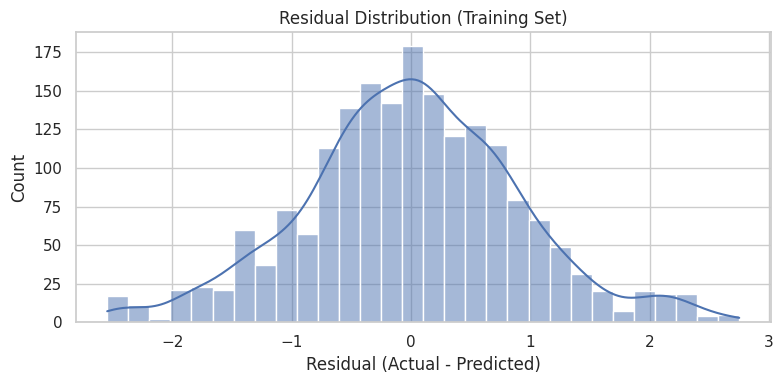

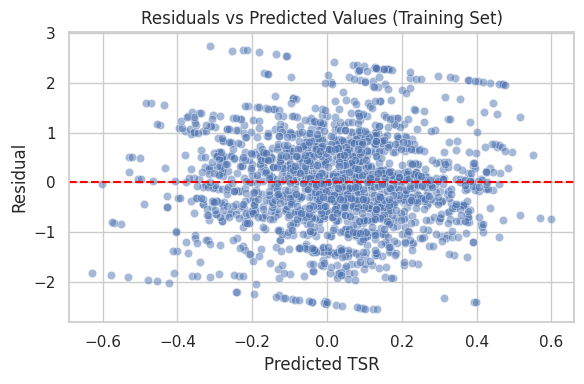


Step 2.3 completed successfully — Residual analysis and visualization done.


In [58]:
# Step 4: Model Error Analysis
# Compute residuals
df_train["predicted"] = model_refit.predict(X_train)
df_train["residual"] = y_train - df_train["predicted"]

sns.set(style="whitegrid")

# Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_train, y=df_train["predicted"], alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--")
plt.title("Actual vs Predicted TSR (Training Set)")
plt.xlabel("Actual TSR")
plt.ylabel("Predicted TSR")
plt.tight_layout()
plt.savefig(W10 / "refit_results" / "plot_actual_vs_predicted.png", dpi=300)
plt.show()

# Residual Distribution
plt.figure(figsize=(8,4))
sns.histplot(df_train["residual"], bins=30, kde=True)
plt.title("Residual Distribution (Training Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.savefig(W10 / "refit_results" / "plot_residual_distribution.png", dpi=300)
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=df_train["predicted"], y=df_train["residual"], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values (Training Set)")
plt.xlabel("Predicted TSR")
plt.ylabel("Residual")
plt.tight_layout()
plt.savefig(W10 / "refit_results" / "plot_residuals_vs_predicted.png", dpi=300)
plt.show()

print("\nStep 2.3 completed successfully — Residual analysis and visualization done.")